# 12 — 3-Level Comparison: IndoBERT-base

Replikasi eksperimen NB11 menggunakan **IndoBERT-base-p2** (~110M params, 768-dim, 12 layers)
sebagai pengganti IndoBERT-large-p2 (~330M params, 1024-dim, 24 layers).

**Hipotesis**: Dengan base model yang lebih kecil, representasi BERT lebih lemah
sehingga komponen tambahan (CRF, MTL) memberikan kontribusi yang lebih signifikan.

| Level | Model | Deskripsi |
|-------|-------|----------|
| 1 | IndoBERT-base + Softmax | Baseline paling basic |
| 2 | IndoBERT-base + CRF | + structural constraint |
| 3 | Hierarchical MTL + CRF | + multi-task learning (Wang et al., 2021) |

Setiap level dijalankan pada **2 dataset** (Original + Augmented) → **6 total runs**, semua di-train dari awal.

**Hyperparameters** (identik dengan NB10/NB11 untuk perbandingan fair):
- 50 epoch, patience=10, Dropout=0.1, WD=0.01
- LR BERT=2e-5, LR Head=1e-4, Batch=4, GradAccum=4
- MTL: λ1=0.3, λ2=0.3, Phase1=3 epochs

**Referensi (IndoBERT-large dari NB11):**

| Model | F1 |
|---|---|
| Penelitian sebelumnya (EMC-GCN) | 0.6761 |
| NB11 L1: Baseline + Original (large) | 0.7466 |
| NB11 L2: ST + Original (large) | 0.7558 |
| NB11 L3: MT + Original (large) | 0.7578 |

In [ ]:
import json
import os
import string
import time
import gc
from collections import Counter
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torchcrf import CRF
from seqeval.metrics import (
    classification_report,
    f1_score as seq_f1_score,
    precision_score as seq_precision_score,
    recall_score as seq_recall_score,
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

PyTorch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.0 GB


### 1. KONFIGURASI

In [2]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

BIEOS_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')
AUG_TRAIN_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_augmented_train.json')
AUG_VAL_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_val.json')
POS_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_positive.tsv')
NEG_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_negative.tsv')
NB11_CHECKPOINT = os.path.join(MODEL_DIR, 'checkpoint_three_level.pt')

# Model — IndoBERT BASE (bukan large)
MODEL_NAME = 'indobenchmark/indobert-base-p2'
MAX_LENGTH = 128
PROJ_DIM = 256

# Training config (sama dengan NB10/NB11)
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 4
NUM_EPOCHS = 50
LR_BERT = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
TRAIN_RATIO = 0.85
DROPOUT = 0.1
IGNORE_INDEX = -100

# Multi-task specific
LAMBDA1 = 0.3
LAMBDA2 = 0.3
PHASE1_EPOCHS = 3
MAX_REL_POS = 20
PATIENCE = 10

SEED = 42
PRIOR_RESEARCH_F1 = 0.6761

# 6 runs: semua level di-train dari awal
RUNS = [
    {'name': 'Baseline + Original',  'model_type': 'baseline',    'data_type': 'original'},
    {'name': 'Baseline + Augmented', 'model_type': 'baseline',    'data_type': 'augmented'},
    {'name': 'ST + Original',        'model_type': 'single_task', 'data_type': 'original'},
    {'name': 'ST + Augmented',       'model_type': 'single_task', 'data_type': 'augmented'},
    {'name': 'MT + Original',        'model_type': 'multi_task',  'data_type': 'original'},
    {'name': 'MT + Augmented',       'model_type': 'multi_task',  'data_type': 'augmented'},
]

print(f'Model: {MODEL_NAME}')
print(f'Total runs: {len(RUNS)}')
print(f'Epochs per run: {NUM_EPOCHS} (patience={PATIENCE})')
print(f'NB11 checkpoint (large): {os.path.exists(NB11_CHECKPOINT)}')
for i, r in enumerate(RUNS):
    print(f'  Run {i+1}: {r["name"]}')

Model: indobenchmark/indobert-base-p2
Total runs: 6
Epochs per run: 50 (patience=10)
NB11 checkpoint (large): True
  Run 1: Baseline + Original
  Run 2: Baseline + Augmented
  Run 3: ST + Original
  Run 4: ST + Augmented
  Run 5: MT + Original
  Run 6: MT + Augmented


### 2. LOAD DATA & TOKENIZER

In [3]:
with open(BIEOS_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

with open(AUG_TRAIN_PATH, 'r', encoding='utf-8') as f:
    raw_aug_train = json.load(f)
with open(AUG_VAL_PATH, 'r', encoding='utf-8') as f:
    raw_aug_val = json.load(f)

def load_lexicon(path):
    words = set()
    with open(path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            parts = line.strip().split('\t')
            if parts:
                word = parts[0].strip().lower()
                if ' ' not in word and len(word) > 1:
                    words.add(word)
    return words

pos_lexicon = load_lexicon(POS_LEX_PATH)
neg_lexicon = load_lexicon(NEG_LEX_PATH)
overlap = pos_lexicon & neg_lexicon
pos_lexicon -= overlap
neg_lexicon -= overlap

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f'Original data: {len(raw_data)}')
print(f'Augmented train: {len(raw_aug_train)}')
print(f'Augmented val: {len(raw_aug_val)}')
print(f'Pos lexicon: {len(pos_lexicon)} | Neg lexicon: {len(neg_lexicon)}')

config.json: 0.00B [00:00, ?B/s]

d:\miniconda3\envs\ta_nlp\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jason\.cache\huggingface\hub\models--indobenchmark--indobert-base-p2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Original data: 2451
Augmented train: 4290
Augmented val: 368
Pos lexicon: 2288 | Neg lexicon: 5025


### 3. LABELS & DATA PREPARATION

In [4]:
ate_labels = ['O', 'B', 'I', 'E', 'S']
sld_labels = ['O', 'POS', 'NEG']
asd_labels = ['O', 'POS', 'NEG', 'NEU']
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']

ate_label2id = {l: i for i, l in enumerate(ate_labels)}
sld_label2id = {l: i for i, l in enumerate(sld_labels)}
asd_label2id = {l: i for i, l in enumerate(asd_labels)}
bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}


def _compute_word_prior(raw_data):
    word_ate_freq = {}
    for d in raw_data:
        for tok, lab in zip(d['tokens'], d['labels']):
            tok_lower = tok.lower()
            if tok_lower not in word_ate_freq:
                word_ate_freq[tok_lower] = [0] * len(ate_labels)
            if lab == 'O':
                word_ate_freq[tok_lower][ate_label2id['O']] += 1
            else:
                word_ate_freq[tok_lower][ate_label2id[lab.split('-')[0]]] += 1
    default_prior = [1.0] + [0.0] * (len(ate_labels) - 1)
    word_prior = {}
    for word, counts in word_ate_freq.items():
        total = sum(counts)
        word_prior[word] = [c / total for c in counts] if total > 0 else default_prior
    return word_prior, default_prior


def _tokenize_mt_samples(raw_data, tokenizer, word_prior, default_prior, pos_lexicon, neg_lexicon):
    all_input_ids, all_attention_mask = [], []
    all_ate, all_sld, all_asd, all_bieos, all_crf, all_prior = [], [], [], [], [], []

    for d in raw_data:
        tokens, labels = d['tokens'], d['labels']
        enc = tokenizer(tokens, is_split_into_words=True,
                        max_length=MAX_LENGTH, padding='max_length',
                        truncation=True, return_tensors='pt')
        word_ids = enc.word_ids(batch_index=0)

        ate_w, sld_w, asd_w = [], [], []
        for tok, lab in zip(tokens, labels):
            if lab == 'O':
                ate_w.append('O'); asd_w.append('O')
            else:
                prefix, sentiment = lab.split('-', 1)
                ate_w.append(prefix); asd_w.append(sentiment)
            t_clean = tok.lower().strip(string.punctuation)
            if t_clean in pos_lexicon:
                sld_w.append('POS')
            elif t_clean in neg_lexicon:
                sld_w.append('NEG')
            else:
                sld_w.append('O')

        ate_a, sld_a, asd_a, bieos_a, crf_a, prior_a = [], [], [], [], [], []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(0); prior_a.append(default_prior)
            elif wid != prev_wid:
                if wid < len(tokens):
                    ate_a.append(ate_label2id[ate_w[wid]])
                    sld_a.append(sld_label2id[sld_w[wid]])
                    asd_a.append(asd_label2id[asd_w[wid]])
                    bieos_a.append(bieos_label2id[labels[wid]])
                    crf_a.append(bieos_label2id[labels[wid]])
                    prior_a.append(word_prior.get(tokens[wid].lower(), default_prior))
                else:
                    ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                    asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                    crf_a.append(0); prior_a.append(default_prior)
            else:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
                prior_a.append(word_prior.get(tokens[wid].lower(), default_prior) if wid < len(tokens) else default_prior)
            prev_wid = wid

        all_input_ids.append(enc['input_ids'].squeeze(0))
        all_attention_mask.append(enc['attention_mask'].squeeze(0))
        all_ate.append(torch.tensor(ate_a, dtype=torch.long))
        all_sld.append(torch.tensor(sld_a, dtype=torch.long))
        all_asd.append(torch.tensor(asd_a, dtype=torch.long))
        all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
        all_crf.append(torch.tensor(crf_a, dtype=torch.long))
        all_prior.append(torch.tensor(prior_a, dtype=torch.float))

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_mask),
        'ate_labels': torch.stack(all_ate),
        'sld_labels': torch.stack(all_sld),
        'asd_labels': torch.stack(all_asd),
        'bieos_labels': torch.stack(all_bieos),
        'crf_labels': torch.stack(all_crf),
        'prior_probs': torch.stack(all_prior),
    }


def _tokenize_st_samples(raw_data, tokenizer):
    all_input_ids, all_attention_mask, all_bieos, all_crf = [], [], [], []

    for d in raw_data:
        tokens, labels = d['tokens'], d['labels']
        enc = tokenizer(tokens, is_split_into_words=True,
                        max_length=MAX_LENGTH, padding='max_length',
                        truncation=True, return_tensors='pt')
        word_ids = enc.word_ids(batch_index=0)

        bieos_a, crf_a = [], []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                bieos_a.append(IGNORE_INDEX); crf_a.append(0)
            elif wid != prev_wid:
                if wid < len(tokens):
                    bieos_a.append(bieos_label2id[labels[wid]])
                    crf_a.append(bieos_label2id[labels[wid]])
                else:
                    bieos_a.append(IGNORE_INDEX); crf_a.append(0)
            else:
                bieos_a.append(IGNORE_INDEX)
                crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
            prev_wid = wid

        all_input_ids.append(enc['input_ids'].squeeze(0))
        all_attention_mask.append(enc['attention_mask'].squeeze(0))
        all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
        all_crf.append(torch.tensor(crf_a, dtype=torch.long))

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_mask),
        'bieos_labels': torch.stack(all_bieos),
        'crf_labels': torch.stack(all_crf),
    }


# Prepare all data
print('Preparing original multi-task data...')
orig_word_prior, default_prior = _compute_word_prior(raw_data)
mt_orig_data = _tokenize_mt_samples(raw_data, tokenizer, orig_word_prior, default_prior, pos_lexicon, neg_lexicon)

print('Preparing original single-task data...')
st_orig_data = _tokenize_st_samples(raw_data, tokenizer)

print('Preparing augmented multi-task data...')
aug_word_prior, _ = _compute_word_prior(raw_aug_train)
mt_aug_train_data = _tokenize_mt_samples(raw_aug_train, tokenizer, aug_word_prior, default_prior, pos_lexicon, neg_lexicon)
mt_aug_val_data = _tokenize_mt_samples(raw_aug_val, tokenizer, aug_word_prior, default_prior, pos_lexicon, neg_lexicon)

print('Preparing augmented single-task data...')
st_aug_train_data = _tokenize_st_samples(raw_aug_train, tokenizer)
st_aug_val_data = _tokenize_st_samples(raw_aug_val, tokenizer)

print(f'\nOriginal: {mt_orig_data["input_ids"].shape[0]} samples')
print(f'Augmented train: {mt_aug_train_data["input_ids"].shape[0]} | val: {mt_aug_val_data["input_ids"].shape[0]}')

Preparing original multi-task data...
Preparing original single-task data...
Preparing augmented multi-task data...
Preparing augmented single-task data...

Original: 2451 samples
Augmented train: 4290 | val: 368


### 4. DATASET & MODEL CLASSES

In [5]:
class ABSADataset(Dataset):
    def __init__(self, data_dict, indices):
        self.data = {k: v[indices] for k, v in data_dict.items()}
    def __len__(self):
        return self.data['input_ids'].size(0)
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


class FullDataset(Dataset):
    def __init__(self, data_dict):
        self.data = data_dict
    def __len__(self):
        return self.data['input_ids'].size(0)
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# --- Level 1: Baseline Softmax ---
class BaselineSoftmaxABSA(nn.Module):
    """IndoBERT + Linear + Softmax (no CRF)."""
    def __init__(self, model_name, num_labels, proj_dim=256, dropout=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size
        self.proj = nn.Sequential(nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.classifier = nn.Linear(proj_dim, num_labels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, bieos_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)
        logits = self.classifier(self.proj(h))
        outputs = {'emissions': logits}
        if bieos_labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
            outputs['loss'] = loss_fn(logits.view(-1, logits.size(-1)), bieos_labels.view(-1))
        return outputs

    def decode(self, emissions, attention_mask):
        preds = emissions.argmax(dim=-1)
        mask = attention_mask.bool()
        return [preds[i][:mask[i].sum().item()].tolist() for i in range(preds.size(0))]


# --- Level 2: Single-Task CRF ---
class SingleTaskABSA(nn.Module):
    """IndoBERT + CRF."""
    def __init__(self, model_name, num_labels, proj_dim=256, dropout=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size
        self.proj = nn.Sequential(nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.emission = nn.Linear(proj_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, crf_labels=None, bieos_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)
        emissions = self.emission(self.proj(h))
        outputs = {'emissions': emissions}
        if crf_labels is not None:
            mask = attention_mask.bool()
            outputs['loss'] = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')
        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())


# --- Level 3: Hierarchical Multi-Task ---
class CrossAttentionASD(nn.Module):
    def __init__(self, dim, max_relative_position=20):
        super().__init__()
        self.max_rel_pos = max_relative_position
        self.pos_embedding = nn.Embedding(2 * max_relative_position + 1, dim)
        self.W_ae = nn.Linear(dim, dim, bias=False)
        self.W_sl = nn.Linear(dim, dim, bias=False)
        self.W_pos = nn.Linear(dim, dim, bias=False)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.w_s = nn.Linear(dim, 1, bias=False)

    def forward(self, h_ae, h_sl, mask=None):
        batch, seq_len, dim = h_ae.shape
        pos = torch.arange(seq_len, device=h_ae.device)
        rel_pos = (pos.unsqueeze(0) - pos.unsqueeze(1)).clamp(
            -self.max_rel_pos, self.max_rel_pos) + self.max_rel_pos
        p_ij = self.pos_embedding(rel_pos)
        s_ae = self.W_ae(h_ae)
        s_sl = self.W_sl(h_sl)
        s_pos = self.W_pos(p_ij)
        combined = s_ae.unsqueeze(2) + s_sl.unsqueeze(1) + s_pos.unsqueeze(0) + self.bias
        scores = self.w_s(torch.tanh(combined)).squeeze(-1)
        if mask is not None:
            scores = scores.masked_fill(~mask.unsqueeze(1), float('-inf'))
        attn_weights = torch.softmax(scores, dim=-1)
        return torch.bmm(attn_weights, h_sl)


class HierarchicalMultiTaskABSA(nn.Module):
    def __init__(self, model_name, num_ate, num_sld, num_asd, num_final,
                 proj_dim=256, dropout=0.1, max_relative_position=20,
                 lambda1=0.3, lambda2=0.3):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.num_sld = num_sld
        self.num_asd = num_asd
        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size
        self.ate_proj = nn.Sequential(nn.Linear(bert_dim + num_ate, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.ate_classifier = nn.Linear(proj_dim, num_ate)
        self.sld_proj = nn.Sequential(nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.sld_classifier = nn.Linear(proj_dim, num_sld)
        self.cross_attention = CrossAttentionASD(proj_dim, max_relative_position)
        self.asd_classifier = nn.Linear(proj_dim, num_asd)
        self.final_proj = nn.Sequential(nn.Linear(proj_dim * 2, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.final_emission = nn.Linear(proj_dim, num_final)
        self.crf = CRF(num_final, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, prior_probs=None,
                ate_labels=None, sld_labels=None, asd_labels=None, crf_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)
        if prior_probs is not None:
            h_with_prior = torch.cat([h, prior_probs], dim=-1)
        else:
            h_with_prior = torch.cat([h, torch.zeros(*h.shape[:-1], self.ate_classifier.out_features, device=h.device)], dim=-1)
        h_ae = self.ate_proj(h_with_prior)
        ate_logits = self.ate_classifier(h_ae)
        h_sl = self.sld_proj(h)
        sld_logits = self.sld_classifier(h_sl)
        mask = attention_mask.bool()
        h_sd = self.cross_attention(h_ae, h_sl, mask=mask)
        asd_logits = self.asd_classifier(h_sd)
        h_concat = torch.cat([h_ae, h_sd], dim=-1)
        emissions = self.final_emission(self.final_proj(h_concat))
        outputs = {'ate_logits': ate_logits, 'sld_logits': sld_logits,
                   'asd_logits': asd_logits, 'emissions': emissions}
        if ate_labels is not None:
            ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
            loss_ate = ce(ate_logits.view(-1, ate_logits.size(-1)), ate_labels.view(-1))
            loss_sld = ce(sld_logits.view(-1, sld_logits.size(-1)), sld_labels.view(-1))
            loss_asd = ce(asd_logits.view(-1, asd_logits.size(-1)), asd_labels.view(-1))
            loss_crf = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')
            outputs['loss'] = self.lambda1 * (loss_ate + loss_sld) + self.lambda2 * loss_asd + loss_crf
            outputs['losses'] = {
                'ate': loss_ate.detach(), 'sld': loss_sld.detach(),
                'asd': loss_asd.detach(), 'crf': loss_crf.detach()}
        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())

    def apply_sentiment_connection(self):
        with torch.no_grad():
            n = min(self.num_sld, self.num_asd)
            self.asd_classifier.weight.data[:n].copy_(self.sld_classifier.weight.data[:n])
            self.asd_classifier.bias.data[:n].copy_(self.sld_classifier.bias.data[:n])


# Show parameter counts
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

print('Model classes defined.')
print(f'\nParameter counts (IndoBERT-base):')
_tmp_bl = BaselineSoftmaxABSA(MODEL_NAME, len(bieos_labels), PROJ_DIM, DROPOUT)
t, tr = count_params(_tmp_bl)
print(f'  L1 Baseline Softmax: {t/1e6:.1f}M params')
del _tmp_bl
_tmp_st = SingleTaskABSA(MODEL_NAME, len(bieos_labels), PROJ_DIM, DROPOUT)
t, tr = count_params(_tmp_st)
print(f'  L2 Single-Task CRF:  {t/1e6:.1f}M params')
del _tmp_st
_tmp_mt = HierarchicalMultiTaskABSA(MODEL_NAME, len(ate_labels), len(sld_labels),
                                     len(asd_labels), len(bieos_labels), PROJ_DIM, DROPOUT, MAX_REL_POS)
t, tr = count_params(_tmp_mt)
print(f'  L3 Multi-Task MTL:   {t/1e6:.1f}M params')
del _tmp_mt
gc.collect()

Model classes defined.

Parameter counts (IndoBERT-base):


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

  L1 Baseline Softmax: 124.6M params


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

  L2 Single-Task CRF:  124.6M params


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

  L3 Multi-Task MTL:   125.2M params


111

### 5. TRAINING & EVALUATION FUNCTIONS

In [6]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_loss += outputs['loss'].item()
            preds = model.decode(outputs['emissions'], batch['attention_mask'])
            bieos_lbl = batch['bieos_labels']
            for i in range(len(preds)):
                pred_seq, true_seq = [], []
                for j in range(len(preds[i])):
                    if bieos_lbl[i][j].item() != IGNORE_INDEX:
                        pred_seq.append(bieos_id2label[preds[i][j]])
                        true_seq.append(bieos_id2label[bieos_lbl[i][j].item()])
                all_preds.append(pred_seq)
                all_true.append(true_seq)
    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_true, all_preds, zero_division=0)
    precision = seq_precision_score(all_true, all_preds, zero_division=0)
    recall = seq_recall_score(all_true, all_preds, zero_division=0)
    return avg_loss, f1, precision, recall, all_true, all_preds


def fmt_time(seconds):
    if seconds < 60:
        return f'{seconds:.0f}s'
    elif seconds < 3600:
        return f'{seconds/60:.1f}m'
    else:
        h = int(seconds // 3600)
        m = int((seconds % 3600) // 60)
        return f'{h}h{m:02d}m'


def train_model(model, train_loader, val_loader, device, num_epochs, patience,
                phase1_epochs=0, desc_prefix='', run_idx=0, total_runs=6,
                global_start_time=None):
    bert_params = list(model.bert.named_parameters())
    head_params = [(n, p) for n, p in model.named_parameters() if not n.startswith('bert')]
    total_epochs = phase1_epochs + num_epochs
    total_steps = (len(train_loader) // GRADIENT_ACCUMULATION) * total_epochs
    warmup_steps = int(total_steps * WARMUP_RATIO)

    optimizer = torch.optim.AdamW([
        {'params': [p for _, p in bert_params], 'lr': LR_BERT},
        {'params': [p for _, p in head_params], 'lr': LR_HEAD},
    ], weight_decay=WEIGHT_DECAY)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_f1 = 0
    best_epoch = 0
    patience_counter = 0
    best_state = None
    has_subtasks = hasattr(model, 'apply_sentiment_connection')
    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_precision': [], 'val_recall': []}
    if has_subtasks:
        history.update({'loss_ate': [], 'loss_sld': [], 'loss_asd': [], 'loss_crf': []})
    epoch_times = []

    def elapsed_total_str():
        if global_start_time is not None:
            return f' | Elapsed: {fmt_time(time.time() - global_start_time)}'
        return ''

    def run_epoch(epoch_num, epoch_label):
        model.train()
        epoch_loss = 0
        epoch_comp = {'ate': 0, 'sld': 0, 'asd': 0, 'crf': 0} if has_subtasks else None
        optimizer.zero_grad()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                    desc=f'  {desc_prefix} {epoch_label}', leave=False)
        for step, batch in pbar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs['loss'] / GRADIENT_ACCUMULATION
            loss.backward()
            if (step + 1) % GRADIENT_ACCUMULATION == 0 or (step + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            epoch_loss += outputs['loss'].item()
            if epoch_comp is not None and 'losses' in outputs:
                for k in epoch_comp:
                    epoch_comp[k] += outputs['losses'][k].item()
            pbar.set_postfix({'loss': f'{epoch_loss/(step+1):.4f}'})
        pbar.close()
        n = len(train_loader)
        avg_comp = {k: v / n for k, v in epoch_comp.items()} if epoch_comp else None
        return epoch_loss / n, avg_comp

    def subtask_str(comp):
        if comp is not None:
            return (f'\n      ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
                    f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')
        return ''

    # Phase 1 (multi-task only)
    if phase1_epochs > 0 and has_subtasks:
        for ep in range(phase1_epochs):
            ep_t0 = time.time()
            train_loss, comp = run_epoch(ep + 1, f'P1 {ep+1}/{phase1_epochs}')
            val_loss, val_f1, val_p, val_r, _, _ = evaluate(model, val_loader, device)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_precision'].append(val_p)
            history['val_recall'].append(val_r)
            if comp:
                for k in comp:
                    history[f'loss_{k}'].append(comp[k])
            ep_elapsed = time.time() - ep_t0
            epoch_times.append(ep_elapsed)
            done_ep = len(epoch_times)
            avg_ep = sum(epoch_times) / done_ep
            remaining_ep = total_epochs - done_ep
            eta_run = avg_ep * remaining_ep
            remaining_runs = total_runs - run_idx - 1
            eta_total = eta_run + (remaining_runs * avg_ep * total_epochs)
            print(f'    P1 {ep+1}/{phase1_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | '
                  f'F1: {val_f1:.4f} P: {val_p:.4f} R: {val_r:.4f} | {fmt_time(ep_elapsed)}/ep | '
                  f'ETA run: {fmt_time(eta_run)} | ETA all: {fmt_time(eta_total)}'
                  f'{elapsed_total_str()}{subtask_str(comp)}', flush=True)
        model.apply_sentiment_connection()
        print(f'    Sentiment Connection applied', flush=True)

    # Main training
    for ep in range(num_epochs):
        global_ep = phase1_epochs + ep + 1
        ep_t0 = time.time()
        train_loss, comp = run_epoch(global_ep, f'Ep {global_ep}/{total_epochs}')
        val_loss, val_f1, val_p, val_r, _, _ = evaluate(model, val_loader, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_p)
        history['val_recall'].append(val_r)
        if comp:
            for k in comp:
                history[f'loss_{k}'].append(comp[k])
        ep_elapsed = time.time() - ep_t0
        epoch_times.append(ep_elapsed)

        improved = val_f1 > best_f1
        if improved:
            best_f1 = val_f1
            best_epoch = global_ep
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        done_ep = len(epoch_times)
        avg_ep = sum(epoch_times) / done_ep
        remaining_ep = total_epochs - done_ep
        if patience_counter > 0:
            remaining_ep = min(remaining_ep, patience - patience_counter)
        eta_run = avg_ep * max(remaining_ep, 0)
        remaining_runs = total_runs - run_idx - 1
        eta_total = eta_run + (remaining_runs * avg_ep * total_epochs)

        print(f'    Ep {global_ep:2d}/{total_epochs} | Train: {train_loss:.4f} | '
              f'Val: {val_loss:.4f} | F1: {val_f1:.4f} P: {val_p:.4f} R: {val_r:.4f} '
              f'{"*" if improved else " "} | {fmt_time(ep_elapsed)}/ep | '
              f'ETA run: {fmt_time(eta_run)} | ETA all: {fmt_time(eta_total)}'
              f'{elapsed_total_str()}{subtask_str(comp)}', flush=True)

        if patience_counter >= patience:
            print(f'    Early stopped at epoch {global_ep}', flush=True)
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    _, final_f1, final_p, final_r, all_true, all_preds = evaluate(model, val_loader, device)
    report = classification_report(all_true, all_preds, zero_division=0)

    return {
        'best_f1': best_f1,
        'best_epoch': best_epoch,
        'epochs_trained': len(history['val_f1']),
        'history': history,
        'report': report,
        'val_true': all_true,
        'val_preds': all_preds,
    }


print('Training functions defined.')

Training functions defined.


### 6. TRAINING LOOP

6 runs secara berurutan: 2 baseline, 2 ST-CRF, 2 MT.
IndoBERT-base ~2x lebih cepat dari large → estimasi ~3-4 jam total.

In [7]:
all_results = {}
run_counter = 0
total_runs = len(RUNS)
global_start = time.time()
run_times = []

# Pre-compute split indices (seed=42, same as NB10/NB11)
total_orig = len(raw_data)
orig_indices = torch.randperm(total_orig, generator=torch.Generator().manual_seed(SEED))
orig_split = int(total_orig * TRAIN_RATIO)

print(f'Original split: train={orig_split}, val={total_orig - orig_split}')
print(f'Starting {total_runs} runs ({MODEL_NAME})')
print(f'Time: {datetime.now().strftime("%H:%M:%S")}\n')

for run_cfg in RUNS:
    run_name = run_cfg['name']
    model_type = run_cfg['model_type']
    data_type = run_cfg['data_type']

    elapsed_so_far = time.time() - global_start
    print(f'\n{"#"*60}')
    print(f'RUN {run_counter+1}/{total_runs}: {run_name}')
    print(f'{datetime.now().strftime("%H:%M:%S")} | Elapsed: {fmt_time(elapsed_so_far)}')
    print(f'{"#"*60}')

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    # Prepare DataLoaders
    if data_type == 'original':
        if model_type == 'multi_task':
            train_ds = ABSADataset(mt_orig_data, orig_indices[:orig_split])
            val_ds = ABSADataset(mt_orig_data, orig_indices[orig_split:])
        else:
            train_ds = ABSADataset(st_orig_data, orig_indices[:orig_split])
            val_ds = ABSADataset(st_orig_data, orig_indices[orig_split:])
    else:
        if model_type == 'multi_task':
            train_ds = FullDataset(mt_aug_train_data)
            val_ds = FullDataset(mt_aug_val_data)
        else:
            train_ds = FullDataset(st_aug_train_data)
            val_ds = FullDataset(st_aug_val_data)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE * 2)

    print(f'  Train: {len(train_ds)} | Val: {len(val_ds)} | Batches: {len(train_loader)}')

    # Create model
    if model_type == 'baseline':
        model = BaselineSoftmaxABSA(
            model_name=MODEL_NAME, num_labels=len(bieos_labels),
            proj_dim=PROJ_DIM, dropout=DROPOUT,
        ).to(device)
        phase1 = 0
        phase2 = NUM_EPOCHS
    elif model_type == 'single_task':
        model = SingleTaskABSA(
            model_name=MODEL_NAME, num_labels=len(bieos_labels),
            proj_dim=PROJ_DIM, dropout=DROPOUT,
        ).to(device)
        phase1 = 0
        phase2 = NUM_EPOCHS
    else:  # multi_task
        model = HierarchicalMultiTaskABSA(
            model_name=MODEL_NAME, num_ate=len(ate_labels), num_sld=len(sld_labels),
            num_asd=len(asd_labels), num_final=len(bieos_labels),
            proj_dim=PROJ_DIM, dropout=DROPOUT, max_relative_position=MAX_REL_POS,
            lambda1=LAMBDA1, lambda2=LAMBDA2,
        ).to(device)
        phase1 = PHASE1_EPOCHS
        phase2 = NUM_EPOCHS - PHASE1_EPOCHS

    t0 = time.time()
    result = train_model(
        model, train_loader, val_loader, device,
        num_epochs=phase2, patience=PATIENCE,
        phase1_epochs=phase1,
        desc_prefix=run_name[:6],
        run_idx=run_counter, total_runs=total_runs,
        global_start_time=global_start,
    )
    result['run_name'] = run_name
    result['model_type'] = model_type
    result['data_type'] = data_type
    result['train_size'] = len(train_ds)
    result['elapsed_min'] = (time.time() - t0) / 60
    all_results[run_name] = result
    run_times.append(time.time() - t0)
    run_counter += 1

    avg_run = sum(run_times) / len(run_times)
    remaining = total_runs - run_counter
    print(f'  >> {run_name}: F1={result["best_f1"]:.4f} (ep {result["best_epoch"]}) | '
          f'Run: {fmt_time(run_times[-1])} | Remaining: {remaining} runs ~{fmt_time(avg_run * remaining)}')

    del model, train_loader, val_loader, train_ds, val_ds
    gc.collect()
    torch.cuda.empty_cache()

    # Intermediate save
    torch.save(all_results, os.path.join(MODEL_DIR, 'base_model_intermediate.pt'))

total_elapsed = time.time() - global_start
print(f'\n{"="*60}')
print(f'ALL RUNS COMPLETED at {datetime.now().strftime("%H:%M:%S")}')
print(f'Total time: {fmt_time(total_elapsed)}')
print(f'{"="*60}')

Original split: train=2083, val=368
Starting 6 runs (indobenchmark/indobert-base-p2)
Time: 21:47:59


############################################################
RUN 1/6: Baseline + Original
21:47:59 | Elapsed: 0s
############################################################
  Train: 2083 | Val: 368 | Batches: 521


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

  Baseli Ep 1/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  1/50 | Train: 1.5326 | Val: 0.5587 | F1: 0.3821 P: 0.4835 R: 0.3159 * | 36s/ep | ETA run: 29.6m | ETA all: 3h00m | Elapsed: 41s


  Baseli Ep 2/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  2/50 | Train: 0.4686 | Val: 0.3525 | F1: 0.5594 P: 0.5979 R: 0.5255 * | 37s/ep | ETA run: 29.1m | ETA all: 3h00m | Elapsed: 1.3m


  Baseli Ep 3/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  3/50 | Train: 0.3240 | Val: 0.2869 | F1: 0.5968 P: 0.6008 R: 0.5927 * | 37s/ep | ETA run: 28.6m | ETA all: 3h00m | Elapsed: 1.9m


  Baseli Ep 4/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/50 | Train: 0.2339 | Val: 0.2566 | F1: 0.6607 P: 0.6297 R: 0.6949 * | 37s/ep | ETA run: 28.1m | ETA all: 3h01m | Elapsed: 2.5m


  Baseli Ep 5/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/50 | Train: 0.1717 | Val: 0.2503 | F1: 0.6838 P: 0.6719 R: 0.6962 * | 37s/ep | ETA run: 27.6m | ETA all: 3h01m | Elapsed: 3.2m


  Baseli Ep 6/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/50 | Train: 0.1169 | Val: 0.2977 | F1: 0.6663 P: 0.6055 R: 0.7406   | 38s/ep | ETA run: 5.5m | ETA all: 2h39m | Elapsed: 3.8m


  Baseli Ep 7/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/50 | Train: 0.0792 | Val: 0.3071 | F1: 0.6788 P: 0.6375 R: 0.7258   | 37s/ep | ETA run: 4.9m | ETA all: 2h39m | Elapsed: 4.4m


  Baseli Ep 8/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/50 | Train: 0.0486 | Val: 0.3573 | F1: 0.6795 P: 0.6484 R: 0.7137   | 38s/ep | ETA run: 4.3m | ETA all: 2h39m | Elapsed: 5.1m


  Baseli Ep 9/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  9/50 | Train: 0.0351 | Val: 0.3975 | F1: 0.6759 P: 0.6377 R: 0.7191   | 38s/ep | ETA run: 3.7m | ETA all: 2h39m | Elapsed: 5.7m


  Baseli Ep 10/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 10/50 | Train: 0.0229 | Val: 0.3944 | F1: 0.7003 P: 0.6675 R: 0.7366 * | 38s/ep | ETA run: 24.9m | ETA all: 3h00m | Elapsed: 6.3m


  Baseli Ep 11/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 11/50 | Train: 0.0169 | Val: 0.4023 | F1: 0.6786 P: 0.6271 R: 0.7392   | 38s/ep | ETA run: 5.6m | ETA all: 2h41m | Elapsed: 7.0m


  Baseli Ep 12/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 12/50 | Train: 0.0123 | Val: 0.4524 | F1: 0.6950 P: 0.6773 R: 0.7137   | 38s/ep | ETA run: 5.0m | ETA all: 2h41m | Elapsed: 7.6m


  Baseli Ep 13/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 13/50 | Train: 0.0140 | Val: 0.4539 | F1: 0.6813 P: 0.6367 R: 0.7325   | 38s/ep | ETA run: 4.4m | ETA all: 2h40m | Elapsed: 8.3m


  Baseli Ep 14/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 14/50 | Train: 0.0109 | Val: 0.4822 | F1: 0.6859 P: 0.6417 R: 0.7366   | 38s/ep | ETA run: 3.8m | ETA all: 2h40m | Elapsed: 8.9m


  Baseli Ep 15/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 15/50 | Train: 0.0061 | Val: 0.5231 | F1: 0.6828 P: 0.6221 R: 0.7567   | 39s/ep | ETA run: 3.1m | ETA all: 2h40m | Elapsed: 9.5m


  Baseli Ep 16/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 16/50 | Train: 0.0068 | Val: 0.5157 | F1: 0.7030 P: 0.6724 R: 0.7366 * | 39s/ep | ETA run: 21.4m | ETA all: 2h58m | Elapsed: 10.2m


  Baseli Ep 17/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 17/50 | Train: 0.0057 | Val: 0.5087 | F1: 0.7073 P: 0.6769 R: 0.7406 * | 39s/ep | ETA run: 20.8m | ETA all: 2h58m | Elapsed: 10.8m


  Baseli Ep 18/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 18/50 | Train: 0.0044 | Val: 0.5122 | F1: 0.6997 P: 0.6720 R: 0.7298   | 38s/ep | ETA run: 5.7m | ETA all: 2h43m | Elapsed: 11.5m


  Baseli Ep 19/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 19/50 | Train: 0.0041 | Val: 0.5306 | F1: 0.7023 P: 0.6745 R: 0.7325   | 39s/ep | ETA run: 5.1m | ETA all: 2h43m | Elapsed: 12.1m


  Baseli Ep 20/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 20/50 | Train: 0.0044 | Val: 0.5095 | F1: 0.7087 P: 0.6999 R: 0.7177 * | 39s/ep | ETA run: 19.0m | ETA all: 2h57m | Elapsed: 12.8m


  Baseli Ep 21/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 21/50 | Train: 0.0036 | Val: 0.5239 | F1: 0.7108 P: 0.6867 R: 0.7366 * | 38s/ep | ETA run: 18.4m | ETA all: 2h56m | Elapsed: 13.4m


  Baseli Ep 22/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 22/50 | Train: 0.0022 | Val: 0.5539 | F1: 0.7096 P: 0.6628 R: 0.7634   | 39s/ep | ETA run: 5.7m | ETA all: 2h44m | Elapsed: 14.1m


  Baseli Ep 23/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 23/50 | Train: 0.0029 | Val: 0.5672 | F1: 0.7069 P: 0.6707 R: 0.7473   | 38s/ep | ETA run: 5.1m | ETA all: 2h43m | Elapsed: 14.7m


  Baseli Ep 24/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 24/50 | Train: 0.0025 | Val: 0.5853 | F1: 0.7081 P: 0.7039 R: 0.7124   | 38s/ep | ETA run: 4.4m | ETA all: 2h43m | Elapsed: 15.4m


  Baseli Ep 25/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 25/50 | Train: 0.0016 | Val: 0.5929 | F1: 0.7104 P: 0.6872 R: 0.7352   | 39s/ep | ETA run: 3.8m | ETA all: 2h42m | Elapsed: 16.0m


  Baseli Ep 26/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 26/50 | Train: 0.0013 | Val: 0.5940 | F1: 0.6992 P: 0.6687 R: 0.7325   | 38s/ep | ETA run: 3.2m | ETA all: 2h41m | Elapsed: 16.6m


  Baseli Ep 27/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 27/50 | Train: 0.0024 | Val: 0.5951 | F1: 0.7060 P: 0.6813 R: 0.7325   | 38s/ep | ETA run: 2.5m | ETA all: 2h41m | Elapsed: 17.3m


  Baseli Ep 28/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 28/50 | Train: 0.0023 | Val: 0.5852 | F1: 0.7091 P: 0.6735 R: 0.7487   | 38s/ep | ETA run: 1.9m | ETA all: 2h40m | Elapsed: 17.9m


  Baseli Ep 29/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 29/50 | Train: 0.0024 | Val: 0.5766 | F1: 0.7226 P: 0.6903 R: 0.7581 * | 38s/ep | ETA run: 13.3m | ETA all: 2h52m | Elapsed: 18.6m


  Baseli Ep 30/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 30/50 | Train: 0.0009 | Val: 0.6050 | F1: 0.7185 P: 0.6942 R: 0.7446   | 38s/ep | ETA run: 5.7m | ETA all: 2h44m | Elapsed: 19.2m


  Baseli Ep 31/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 31/50 | Train: 0.0005 | Val: 0.6252 | F1: 0.7122 P: 0.6836 R: 0.7433   | 38s/ep | ETA run: 5.1m | ETA all: 2h43m | Elapsed: 19.8m


  Baseli Ep 32/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 32/50 | Train: 0.0006 | Val: 0.6130 | F1: 0.6992 P: 0.6687 R: 0.7325   | 38s/ep | ETA run: 4.4m | ETA all: 2h43m | Elapsed: 20.4m


  Baseli Ep 33/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 33/50 | Train: 0.0006 | Val: 0.6229 | F1: 0.7071 P: 0.6731 R: 0.7446   | 38s/ep | ETA run: 3.8m | ETA all: 2h42m | Elapsed: 21.1m


  Baseli Ep 34/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 34/50 | Train: 0.0004 | Val: 0.6295 | F1: 0.7161 P: 0.6991 R: 0.7339   | 38s/ep | ETA run: 3.2m | ETA all: 2h41m | Elapsed: 21.7m


  Baseli Ep 35/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 35/50 | Train: 0.0014 | Val: 0.6086 | F1: 0.7198 P: 0.6955 R: 0.7460   | 38s/ep | ETA run: 2.5m | ETA all: 2h41m | Elapsed: 22.3m


  Baseli Ep 36/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 36/50 | Train: 0.0004 | Val: 0.6187 | F1: 0.7201 P: 0.6936 R: 0.7487   | 38s/ep | ETA run: 1.9m | ETA all: 2h40m | Elapsed: 23.0m


  Baseli Ep 37/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 37/50 | Train: 0.0003 | Val: 0.6247 | F1: 0.7171 P: 0.6803 R: 0.7581   | 38s/ep | ETA run: 1.3m | ETA all: 2h39m | Elapsed: 23.6m


  Baseli Ep 38/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 38/50 | Train: 0.0007 | Val: 0.6279 | F1: 0.7277 P: 0.7044 R: 0.7527 * | 38s/ep | ETA run: 7.6m | ETA all: 2h46m | Elapsed: 24.2m


  Baseli Ep 39/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 39/50 | Train: 0.0008 | Val: 0.6428 | F1: 0.7060 P: 0.6627 R: 0.7554   | 38s/ep | ETA run: 5.7m | ETA all: 2h44m | Elapsed: 24.9m


  Baseli Ep 40/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 40/50 | Train: 0.0003 | Val: 0.6292 | F1: 0.7153 P: 0.6882 R: 0.7446   | 38s/ep | ETA run: 5.1m | ETA all: 2h43m | Elapsed: 25.5m


  Baseli Ep 41/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 41/50 | Train: 0.0004 | Val: 0.6348 | F1: 0.7147 P: 0.6847 R: 0.7473   | 38s/ep | ETA run: 4.4m | ETA all: 2h42m | Elapsed: 26.1m


  Baseli Ep 42/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 42/50 | Train: 0.0003 | Val: 0.6340 | F1: 0.7209 P: 0.6986 R: 0.7446   | 38s/ep | ETA run: 3.8m | ETA all: 2h42m | Elapsed: 26.8m


  Baseli Ep 43/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 43/50 | Train: 0.0002 | Val: 0.6408 | F1: 0.7138 P: 0.6788 R: 0.7527   | 38s/ep | ETA run: 3.2m | ETA all: 2h41m | Elapsed: 27.4m


  Baseli Ep 44/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 44/50 | Train: 0.0001 | Val: 0.6394 | F1: 0.7171 P: 0.6859 R: 0.7513   | 38s/ep | ETA run: 2.5m | ETA all: 2h40m | Elapsed: 28.0m


  Baseli Ep 45/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 45/50 | Train: 0.0001 | Val: 0.6390 | F1: 0.7194 P: 0.6901 R: 0.7513   | 38s/ep | ETA run: 1.9m | ETA all: 2h40m | Elapsed: 28.7m


  Baseli Ep 46/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 46/50 | Train: 0.0001 | Val: 0.6453 | F1: 0.7115 P: 0.6735 R: 0.7540   | 38s/ep | ETA run: 1.3m | ETA all: 2h39m | Elapsed: 29.3m


  Baseli Ep 47/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 47/50 | Train: 0.0001 | Val: 0.6448 | F1: 0.7129 P: 0.6718 R: 0.7594   | 38s/ep | ETA run: 38s | ETA all: 2h39m | Elapsed: 29.9m


  Baseli Ep 48/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 48/50 | Train: 0.0002 | Val: 0.6471 | F1: 0.7181 P: 0.6778 R: 0.7634   | 38s/ep | ETA run: 0s | ETA all: 2h38m | Elapsed: 30.6m
    Early stopped at epoch 48
  >> Baseline + Original: F1=0.7277 (ep 38) | Run: 30.5m | Remaining: 5 runs ~2h32m

############################################################
RUN 2/6: Baseline + Augmented
22:18:35 | Elapsed: 30.6m
############################################################
  Train: 4290 | Val: 368 | Batches: 1073


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

  Baseli Ep 1/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  1/50 | Train: 1.2238 | Val: 0.4326 | F1: 0.4798 P: 0.5171 R: 0.4476 * | 1.3m/ep | ETA run: 1h02m | ETA all: 5h16m | Elapsed: 31.9m


  Baseli Ep 2/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  2/50 | Train: 0.3739 | Val: 0.2768 | F1: 0.6257 P: 0.5916 R: 0.6640 * | 1.3m/ep | ETA run: 1h00m | ETA all: 5h14m | Elapsed: 33.2m


  Baseli Ep 3/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  3/50 | Train: 0.2041 | Val: 0.2513 | F1: 0.6967 P: 0.6972 R: 0.6962 * | 1.3m/ep | ETA run: 59.5m | ETA all: 5h12m | Elapsed: 34.5m


  Baseli Ep 4/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  4/50 | Train: 0.1037 | Val: 0.3151 | F1: 0.6759 P: 0.6134 R: 0.7527   | 1.3m/ep | ETA run: 11.4m | ETA all: 4h24m | Elapsed: 35.7m


  Baseli Ep 5/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  5/50 | Train: 0.0635 | Val: 0.3616 | F1: 0.6608 P: 0.5897 R: 0.7513   | 1.3m/ep | ETA run: 10.1m | ETA all: 4h23m | Elapsed: 37.0m


  Baseli Ep 6/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  6/50 | Train: 0.0391 | Val: 0.4064 | F1: 0.6671 P: 0.6171 R: 0.7258   | 1.3m/ep | ETA run: 8.9m | ETA all: 4h21m | Elapsed: 38.3m


  Baseli Ep 7/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  7/50 | Train: 0.0238 | Val: 0.4091 | F1: 0.6787 P: 0.6733 R: 0.6841   | 1.3m/ep | ETA run: 7.6m | ETA all: 4h20m | Elapsed: 39.5m


  Baseli Ep 8/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  8/50 | Train: 0.0147 | Val: 0.4302 | F1: 0.6941 P: 0.6563 R: 0.7366   | 1.3m/ep | ETA run: 6.3m | ETA all: 4h19m | Elapsed: 40.8m


  Baseli Ep 9/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  9/50 | Train: 0.0111 | Val: 0.4603 | F1: 0.6881 P: 0.6488 R: 0.7325   | 1.3m/ep | ETA run: 5.1m | ETA all: 4h17m | Elapsed: 42.0m


  Baseli Ep 10/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 10/50 | Train: 0.0074 | Val: 0.4897 | F1: 0.7002 P: 0.6516 R: 0.7567 * | 1.3m/ep | ETA run: 50.5m | ETA all: 5h03m | Elapsed: 43.3m


  Baseli Ep 11/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 11/50 | Train: 0.0065 | Val: 0.5033 | F1: 0.7001 P: 0.6716 R: 0.7312   | 1.3m/ep | ETA run: 11.4m | ETA all: 4h23m | Elapsed: 44.6m


  Baseli Ep 12/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 12/50 | Train: 0.0052 | Val: 0.5244 | F1: 0.7102 P: 0.6723 R: 0.7527 * | 1.3m/ep | ETA run: 48.0m | ETA all: 5h00m | Elapsed: 45.8m


  Baseli Ep 13/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 13/50 | Train: 0.0042 | Val: 0.5681 | F1: 0.6909 P: 0.6570 R: 0.7285   | 1.3m/ep | ETA run: 11.4m | ETA all: 4h23m | Elapsed: 47.1m


  Baseli Ep 14/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 14/50 | Train: 0.0038 | Val: 0.5707 | F1: 0.6860 P: 0.6450 R: 0.7325   | 1.3m/ep | ETA run: 10.1m | ETA all: 4h22m | Elapsed: 48.3m


  Baseli Ep 15/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 15/50 | Train: 0.0056 | Val: 0.5687 | F1: 0.7049 P: 0.6839 R: 0.7272   | 1.3m/ep | ETA run: 8.8m | ETA all: 4h21m | Elapsed: 49.6m


  Baseli Ep 16/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 16/50 | Train: 0.0052 | Val: 0.5830 | F1: 0.6996 P: 0.6619 R: 0.7419   | 1.3m/ep | ETA run: 7.6m | ETA all: 4h19m | Elapsed: 50.9m


  Baseli Ep 17/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 17/50 | Train: 0.0029 | Val: 0.5959 | F1: 0.6965 P: 0.6471 R: 0.7540   | 1.3m/ep | ETA run: 6.3m | ETA all: 4h18m | Elapsed: 52.1m


  Baseli Ep 18/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 18/50 | Train: 0.0032 | Val: 0.6021 | F1: 0.7008 P: 0.6683 R: 0.7366   | 1.3m/ep | ETA run: 5.0m | ETA all: 4h17m | Elapsed: 53.4m


  Baseli Ep 19/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 19/50 | Train: 0.0025 | Val: 0.6160 | F1: 0.6912 P: 0.6439 R: 0.7460   | 1.3m/ep | ETA run: 3.8m | ETA all: 4h15m | Elapsed: 54.6m


  Baseli Ep 20/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 20/50 | Train: 0.0029 | Val: 0.5961 | F1: 0.6904 P: 0.6445 R: 0.7433   | 1.3m/ep | ETA run: 2.5m | ETA all: 4h14m | Elapsed: 55.9m


  Baseli Ep 21/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 21/50 | Train: 0.0030 | Val: 0.6018 | F1: 0.6853 P: 0.6356 R: 0.7433   | 1.3m/ep | ETA run: 1.3m | ETA all: 4h13m | Elapsed: 57.1m


  Baseli Ep 22/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 22/50 | Train: 0.0016 | Val: 0.6222 | F1: 0.6991 P: 0.6754 R: 0.7245   | 1.3m/ep | ETA run: 0s | ETA all: 4h11m | Elapsed: 58.4m
    Early stopped at epoch 22
  >> Baseline + Augmented: F1=0.7102 (ep 12) | Run: 27.8m | Remaining: 4 runs ~1h56m

############################################################
RUN 3/6: ST + Original
22:46:25 | Elapsed: 58.4m
############################################################
  Train: 2083 | Val: 368 | Batches: 521


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

  ST + O Ep 1/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  1/50 | Train: 40.1104 | Val: 13.4870 | F1: 0.3699 P: 0.5994 R: 0.2675 * | 2.5m/ep | ETA run: 2h01m | ETA all: 8h12m | Elapsed: 1h00m


  ST + O Ep 2/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  2/50 | Train: 11.5820 | Val: 8.7397 | F1: 0.5369 P: 0.5458 R: 0.5282 * | 2.4m/ep | ETA run: 1h57m | ETA all: 8h05m | Elapsed: 1h03m


  ST + O Ep 3/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  3/50 | Train: 8.1568 | Val: 7.3326 | F1: 0.5786 P: 0.5228 R: 0.6478 * | 2.3m/ep | ETA run: 1h53m | ETA all: 7h55m | Elapsed: 1h05m


  ST + O Ep 4/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/50 | Train: 5.8893 | Val: 6.1448 | F1: 0.6469 P: 0.6332 R: 0.6613 * | 2.4m/ep | ETA run: 1h51m | ETA all: 7h54m | Elapsed: 1h08m


  ST + O Ep 5/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/50 | Train: 4.2113 | Val: 6.1570 | F1: 0.6740 P: 0.6532 R: 0.6962 * | 2.5m/ep | ETA run: 1h49m | ETA all: 7h53m | Elapsed: 1h10m


  ST + O Ep 6/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/50 | Train: 2.8379 | Val: 7.2812 | F1: 0.6796 P: 0.6369 R: 0.7285 * | 2.3m/ep | ETA run: 1h45m | ETA all: 7h47m | Elapsed: 1h12m


  ST + O Ep 7/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/50 | Train: 1.8272 | Val: 7.5805 | F1: 0.6683 P: 0.6253 R: 0.7177   | 2.5m/ep | ETA run: 21.8m | ETA all: 6h25m | Elapsed: 1h15m


  ST + O Ep 8/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/50 | Train: 1.1446 | Val: 8.1234 | F1: 0.6886 P: 0.6877 R: 0.6895 * | 2.5m/ep | ETA run: 1h42m | ETA all: 7h46m | Elapsed: 1h17m


  ST + O Ep 9/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  9/50 | Train: 0.7966 | Val: 9.3815 | F1: 0.6901 P: 0.6482 R: 0.7379 * | 2.5m/ep | ETA run: 1h39m | ETA all: 7h45m | Elapsed: 1h20m


  ST + O Ep 10/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 10/50 | Train: 0.6227 | Val: 9.3429 | F1: 0.6879 P: 0.6538 R: 0.7258   | 2.4m/ep | ETA run: 21.8m | ETA all: 6h25m | Elapsed: 1h22m


  ST + O Ep 11/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 11/50 | Train: 0.4101 | Val: 10.9308 | F1: 0.6999 P: 0.6531 R: 0.7540 * | 2.3m/ep | ETA run: 1h34m | ETA all: 7h36m | Elapsed: 1h25m


  ST + O Ep 12/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 12/50 | Train: 0.3562 | Val: 10.9023 | F1: 0.6893 P: 0.6688 R: 0.7110   | 2.3m/ep | ETA run: 21.7m | ETA all: 6h23m | Elapsed: 1h27m


  ST + O Ep 13/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 13/50 | Train: 0.3182 | Val: 11.7698 | F1: 0.6951 P: 0.6518 R: 0.7446   | 2.3m/ep | ETA run: 19.2m | ETA all: 6h19m | Elapsed: 1h29m


  ST + O Ep 14/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 14/50 | Train: 0.2309 | Val: 12.5003 | F1: 0.6978 P: 0.6650 R: 0.7339   | 2.3m/ep | ETA run: 16.8m | ETA all: 6h16m | Elapsed: 1h32m


  ST + O Ep 15/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 15/50 | Train: 0.2318 | Val: 13.4570 | F1: 0.6992 P: 0.6611 R: 0.7419   | 2.3m/ep | ETA run: 14.3m | ETA all: 6h12m | Elapsed: 1h34m


  ST + O Ep 16/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 16/50 | Train: 0.2158 | Val: 15.0835 | F1: 0.6973 P: 0.6486 R: 0.7540   | 2.3m/ep | ETA run: 11.9m | ETA all: 6h09m | Elapsed: 1h36m


  ST + O Ep 17/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 17/50 | Train: 0.1383 | Val: 14.5675 | F1: 0.7070 P: 0.6786 R: 0.7379 * | 2.3m/ep | ETA run: 1h18m | ETA all: 7h15m | Elapsed: 1h39m


  ST + O Ep 18/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 18/50 | Train: 0.1962 | Val: 14.2639 | F1: 0.7018 P: 0.6792 R: 0.7258   | 2.3m/ep | ETA run: 21.4m | ETA all: 6h17m | Elapsed: 1h41m


  ST + O Ep 19/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 19/50 | Train: 0.1565 | Val: 14.9700 | F1: 0.7065 P: 0.6699 R: 0.7473   | 2.3m/ep | ETA run: 19.0m | ETA all: 6h15m | Elapsed: 1h43m


  ST + O Ep 20/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 20/50 | Train: 0.1635 | Val: 14.8346 | F1: 0.7092 P: 0.6946 R: 0.7245 * | 2.3m/ep | ETA run: 1h11m | ETA all: 7h06m | Elapsed: 1h45m


  ST + O Ep 21/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 21/50 | Train: 0.0853 | Val: 15.8652 | F1: 0.6997 P: 0.6789 R: 0.7218   | 2.3m/ep | ETA run: 21.3m | ETA all: 6h16m | Elapsed: 1h48m


  ST + O Ep 22/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 22/50 | Train: 0.1181 | Val: 15.4236 | F1: 0.7086 P: 0.6851 R: 0.7339   | 2.3m/ep | ETA run: 18.9m | ETA all: 6h13m | Elapsed: 1h50m


  ST + O Ep 23/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 23/50 | Train: 0.0950 | Val: 15.9478 | F1: 0.6916 P: 0.6743 R: 0.7097   | 2.4m/ep | ETA run: 16.6m | ETA all: 6h11m | Elapsed: 1h52m


  ST + O Ep 24/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 24/50 | Train: 0.1040 | Val: 17.6170 | F1: 0.6915 P: 0.6424 R: 0.7487   | 2.5m/ep | ETA run: 14.2m | ETA all: 6h09m | Elapsed: 1h55m


  ST + O Ep 25/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 25/50 | Train: 0.0718 | Val: 17.3245 | F1: 0.7167 P: 0.6967 R: 0.7379 * | 2.4m/ep | ETA run: 59.3m | ETA all: 6h55m | Elapsed: 1h57m


  ST + O Ep 26/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 26/50 | Train: 0.0706 | Val: 18.1640 | F1: 0.6946 P: 0.6488 R: 0.7473   | 2.3m/ep | ETA run: 21.3m | ETA all: 6h16m | Elapsed: 2h00m


  ST + O Ep 27/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 27/50 | Train: 0.0317 | Val: 18.3380 | F1: 0.7048 P: 0.6679 R: 0.7460   | 2.3m/ep | ETA run: 18.9m | ETA all: 6h14m | Elapsed: 2h02m


  ST + O Ep 28/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 28/50 | Train: 0.0463 | Val: 18.1229 | F1: 0.6927 P: 0.6602 R: 0.7285   | 2.3m/ep | ETA run: 16.6m | ETA all: 6h11m | Elapsed: 2h04m


  ST + O Ep 29/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 29/50 | Train: 0.0704 | Val: 18.3608 | F1: 0.7009 P: 0.6708 R: 0.7339   | 2.3m/ep | ETA run: 14.2m | ETA all: 6h08m | Elapsed: 2h07m


  ST + O Ep 30/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 30/50 | Train: 0.0352 | Val: 18.8225 | F1: 0.7104 P: 0.6945 R: 0.7272   | 2.3m/ep | ETA run: 11.8m | ETA all: 6h06m | Elapsed: 2h09m


  ST + O Ep 31/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 31/50 | Train: 0.0461 | Val: 18.9761 | F1: 0.6959 P: 0.6696 R: 0.7245   | 2.3m/ep | ETA run: 9.4m | ETA all: 6h03m | Elapsed: 2h11m


  ST + O Ep 32/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 32/50 | Train: 0.0220 | Val: 19.1785 | F1: 0.7154 P: 0.6895 R: 0.7433   | 2.3m/ep | ETA run: 7.1m | ETA all: 6h01m | Elapsed: 2h14m


  ST + O Ep 33/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 33/50 | Train: 0.0174 | Val: 19.6321 | F1: 0.7057 P: 0.6843 R: 0.7285   | 2.3m/ep | ETA run: 4.7m | ETA all: 5h58m | Elapsed: 2h16m


  ST + O Ep 34/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 34/50 | Train: 0.0231 | Val: 19.8184 | F1: 0.7035 P: 0.6745 R: 0.7352   | 2.3m/ep | ETA run: 2.4m | ETA all: 5h56m | Elapsed: 2h18m


  ST + O Ep 35/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 35/50 | Train: 0.0286 | Val: 18.8844 | F1: 0.7262 P: 0.7099 R: 0.7433 * | 2.3m/ep | ETA run: 35.4m | ETA all: 6h28m | Elapsed: 2h21m


  ST + O Ep 36/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 36/50 | Train: 0.0254 | Val: 20.4560 | F1: 0.7022 P: 0.6643 R: 0.7446   | 2.3m/ep | ETA run: 21.2m | ETA all: 6h14m | Elapsed: 2h23m


  ST + O Ep 37/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 37/50 | Train: 0.0209 | Val: 20.2453 | F1: 0.7152 P: 0.6927 R: 0.7392   | 2.3m/ep | ETA run: 18.8m | ETA all: 6h12m | Elapsed: 2h25m


  ST + O Ep 38/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 38/50 | Train: 0.0155 | Val: 20.1975 | F1: 0.7046 P: 0.6787 R: 0.7325   | 2.3m/ep | ETA run: 16.5m | ETA all: 6h09m | Elapsed: 2h27m


  ST + O Ep 39/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 39/50 | Train: 0.0388 | Val: 20.5198 | F1: 0.7134 P: 0.6780 R: 0.7527   | 2.3m/ep | ETA run: 14.1m | ETA all: 6h06m | Elapsed: 2h30m


  ST + O Ep 40/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 40/50 | Train: 0.0101 | Val: 20.2186 | F1: 0.7152 P: 0.6869 R: 0.7460   | 2.3m/ep | ETA run: 11.8m | ETA all: 6h04m | Elapsed: 2h32m


  ST + O Ep 41/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 41/50 | Train: 0.0062 | Val: 19.7688 | F1: 0.7217 P: 0.7037 R: 0.7406   | 2.3m/ep | ETA run: 9.4m | ETA all: 6h01m | Elapsed: 2h34m


  ST + O Ep 42/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 42/50 | Train: 0.0054 | Val: 19.4345 | F1: 0.7146 P: 0.6950 R: 0.7352   | 2.3m/ep | ETA run: 7.1m | ETA all: 5h59m | Elapsed: 2h37m


  ST + O Ep 43/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 43/50 | Train: 0.0045 | Val: 19.3661 | F1: 0.7187 P: 0.7017 R: 0.7366   | 2.3m/ep | ETA run: 4.7m | ETA all: 5h57m | Elapsed: 2h39m


  ST + O Ep 44/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 44/50 | Train: 0.0024 | Val: 19.2781 | F1: 0.7139 P: 0.6974 R: 0.7312   | 2.3m/ep | ETA run: 2.3m | ETA all: 5h54m | Elapsed: 2h41m


  ST + O Ep 45/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 45/50 | Train: 0.0024 | Val: 18.9037 | F1: 0.7208 P: 0.7082 R: 0.7339   | 2.3m/ep | ETA run: 0s | ETA all: 5h52m | Elapsed: 2h44m
    Early stopped at epoch 45
  >> ST + Original: F1=0.7262 (ep 35) | Run: 1h45m | Remaining: 3 runs ~2h44m

############################################################
RUN 4/6: ST + Augmented
00:32:18 | Elapsed: 2h44m
############################################################
  Train: 4290 | Val: 368 | Batches: 1073


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

  ST + A Ep 1/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  1/50 | Train: 37.9770 | Val: 10.8982 | F1: 0.4501 P: 0.5251 R: 0.3938 * | 4.6m/ep | ETA run: 3h47m | ETA all: 11h32m | Elapsed: 2h49m


  ST + A Ep 2/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  2/50 | Train: 11.3395 | Val: 7.7545 | F1: 0.6108 P: 0.5474 R: 0.6909 * | 4.6m/ep | ETA run: 3h42m | ETA all: 11h27m | Elapsed: 2h53m


  ST + A Ep 3/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  3/50 | Train: 5.9593 | Val: 6.9856 | F1: 0.6732 P: 0.6151 R: 0.7433 * | 4.6m/ep | ETA run: 3h38m | ETA all: 11h22m | Elapsed: 2h58m


  ST + A Ep 4/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  4/50 | Train: 3.0439 | Val: 7.9146 | F1: 0.6710 P: 0.6429 R: 0.7016   | 4.8m/ep | ETA run: 42.2m | ETA all: 8h30m | Elapsed: 3h03m


  ST + A Ep 5/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  5/50 | Train: 1.6984 | Val: 9.0709 | F1: 0.6922 P: 0.6792 R: 0.7056 * | 4.6m/ep | ETA run: 3h30m | ETA all: 11h18m | Elapsed: 3h07m


  ST + A Ep 6/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  6/50 | Train: 0.9927 | Val: 9.9293 | F1: 0.6763 P: 0.6586 R: 0.6949   | 4.7m/ep | ETA run: 42.2m | ETA all: 8h30m | Elapsed: 3h12m


  ST + A Ep 7/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  7/50 | Train: 0.6309 | Val: 10.1294 | F1: 0.6827 P: 0.6625 R: 0.7043   | 4.7m/ep | ETA run: 37.5m | ETA all: 8h25m | Elapsed: 3h17m


  ST + A Ep 8/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  8/50 | Train: 0.4952 | Val: 12.2212 | F1: 0.6815 P: 0.6312 R: 0.7406   | 4.7m/ep | ETA run: 32.8m | ETA all: 8h21m | Elapsed: 3h21m


  ST + A Ep 9/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  9/50 | Train: 0.3621 | Val: 12.1641 | F1: 0.6926 P: 0.6415 R: 0.7527 * | 4.7m/ep | ETA run: 3h12m | ETA all: 11h00m | Elapsed: 3h26m


  ST + A Ep 10/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 10/50 | Train: 0.3014 | Val: 14.1314 | F1: 0.6785 P: 0.6251 R: 0.7419   | 4.7m/ep | ETA run: 42.2m | ETA all: 8h30m | Elapsed: 3h31m


  ST + A Ep 11/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 11/50 | Train: 0.2412 | Val: 14.2430 | F1: 0.6814 P: 0.6421 R: 0.7258   | 4.7m/ep | ETA run: 37.5m | ETA all: 8h25m | Elapsed: 3h35m


  ST + A Ep 12/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 12/50 | Train: 0.2399 | Val: 15.8809 | F1: 0.6865 P: 0.6357 R: 0.7460   | 4.7m/ep | ETA run: 32.8m | ETA all: 8h21m | Elapsed: 3h40m


  ST + A Ep 13/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 13/50 | Train: 0.1926 | Val: 17.5661 | F1: 0.6894 P: 0.6398 R: 0.7473   | 4.8m/ep | ETA run: 28.2m | ETA all: 8h17m | Elapsed: 3h45m


  ST + A Ep 14/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 14/50 | Train: 0.1464 | Val: 17.3784 | F1: 0.7194 P: 0.7118 R: 0.7272 * | 4.7m/ep | ETA run: 2h49m | ETA all: 10h38m | Elapsed: 3h50m


  ST + A Ep 15/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 15/50 | Train: 0.1465 | Val: 18.2328 | F1: 0.7085 P: 0.6837 R: 0.7352   | 4.7m/ep | ETA run: 42.3m | ETA all: 8h31m | Elapsed: 3h54m


  ST + A Ep 16/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 16/50 | Train: 0.1393 | Val: 18.5366 | F1: 0.6953 P: 0.6563 R: 0.7392   | 4.7m/ep | ETA run: 37.6m | ETA all: 8h26m | Elapsed: 3h59m


  ST + A Ep 17/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 17/50 | Train: 0.0865 | Val: 19.5468 | F1: 0.7141 P: 0.6771 R: 0.7554   | 4.8m/ep | ETA run: 32.9m | ETA all: 8h22m | Elapsed: 4h04m


  ST + A Ep 18/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 18/50 | Train: 0.1161 | Val: 19.3924 | F1: 0.7060 P: 0.6757 R: 0.7392   | 4.7m/ep | ETA run: 28.2m | ETA all: 8h18m | Elapsed: 4h09m


  ST + A Ep 19/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 19/50 | Train: 0.1029 | Val: 19.4258 | F1: 0.7126 P: 0.6844 R: 0.7433   | 5.0m/ep | ETA run: 23.6m | ETA all: 8h15m | Elapsed: 4h14m


  ST + A Ep 20/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 20/50 | Train: 0.1061 | Val: 18.9495 | F1: 0.7055 P: 0.6671 R: 0.7487   | 4.9m/ep | ETA run: 18.9m | ETA all: 8h11m | Elapsed: 4h18m


  ST + A Ep 21/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 21/50 | Train: 0.1922 | Val: 26.8351 | F1: 0.7114 P: 0.6903 R: 0.7339   | 5.0m/ep | ETA run: 14.2m | ETA all: 8h08m | Elapsed: 4h24m


  ST + A Ep 22/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 22/50 | Train: 0.1541 | Val: 33.0240 | F1: 0.7079 P: 0.6803 R: 0.7379   | 4.7m/ep | ETA run: 9.5m | ETA all: 8h03m | Elapsed: 4h28m


  ST + A Ep 23/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 23/50 | Train: 0.2144 | Val: 35.3899 | F1: 0.6983 P: 0.6595 R: 0.7419   | 4.7m/ep | ETA run: 4.7m | ETA all: 7h58m | Elapsed: 4h33m


  ST + A Ep 24/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 24/50 | Train: 0.1256 | Val: 37.3081 | F1: 0.6965 P: 0.6638 R: 0.7325   | 4.7m/ep | ETA run: 0s | ETA all: 7h53m | Elapsed: 4h38m
    Early stopped at epoch 24
  >> ST + Augmented: F1=0.7194 (ep 14) | Run: 1h53m | Remaining: 2 runs ~2h18m

############################################################
RUN 5/6: MT + Original
02:26:11 | Elapsed: 4h38m
############################################################
  Train: 2083 | Val: 368 | Batches: 521


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

  MT + O P1 1/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 1/3 | Train: 46.2220 | Val: 19.0011 | F1: 0.0000 P: 0.0000 R: 0.0000 | 2.6m/ep | ETA run: 2h07m | ETA all: 4h16m | Elapsed: 4h40m
      ATE:1.643  SLD:0.971  ASD:1.074  CRF:45.116


  MT + O P1 2/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 2/3 | Train: 15.1963 | Val: 11.5780 | F1: 0.4003 P: 0.4310 R: 0.3737 | 2.6m/ep | ETA run: 2h04m | ETA all: 4h14m | Elapsed: 4h43m
      ATE:0.578  SLD:0.777  ASD:0.600  CRF:14.610


  MT + O P1 3/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 3/3 | Train: 10.3943 | Val: 8.8742 | F1: 0.5513 P: 0.5073 R: 0.6035 | 2.6m/ep | ETA run: 2h01m | ETA all: 4h11m | Elapsed: 4h46m
      ATE:0.350  SLD:0.753  ASD:0.547  CRF:9.899
    Sentiment Connection applied


  MT + O Ep 4/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/50 | Train: 7.1869 | Val: 6.9347 | F1: 0.6461 P: 0.6597 R: 0.6331 * | 2.6m/ep | ETA run: 1h59m | ETA all: 4h09m | Elapsed: 4h48m
      ATE:0.253  SLD:0.744  ASD:0.546  CRF:6.724


  MT + O Ep 5/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/50 | Train: 5.1690 | Val: 7.1174 | F1: 0.6653 P: 0.6736 R: 0.6573 * | 2.6m/ep | ETA run: 1h56m | ETA all: 4h06m | Elapsed: 4h51m
      ATE:0.193  SLD:0.731  ASD:0.455  CRF:4.755


  MT + O Ep 6/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/50 | Train: 3.5348 | Val: 7.1278 | F1: 0.6733 P: 0.6300 R: 0.7231 * | 2.4m/ep | ETA run: 1h52m | ETA all: 4h01m | Elapsed: 4h53m
      ATE:0.132  SLD:0.720  ASD:0.380  CRF:3.165


  MT + O Ep 7/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/50 | Train: 2.3284 | Val: 7.9231 | F1: 0.6859 P: 0.6439 R: 0.7339 * | 2.4m/ep | ETA run: 1h49m | ETA all: 3h56m | Elapsed: 4h56m
      ATE:0.093  SLD:0.703  ASD:0.306  CRF:1.998


  MT + O Ep 8/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/50 | Train: 1.7031 | Val: 9.8244 | F1: 0.6743 P: 0.6144 R: 0.7473   | 2.4m/ep | ETA run: 22.7m | ETA all: 2h28m | Elapsed: 4h58m
      ATE:0.066  SLD:0.676  ASD:0.229  CRF:1.412


  MT + O Ep 9/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  9/50 | Train: 1.2509 | Val: 10.2407 | F1: 0.6765 P: 0.6463 R: 0.7097   | 2.5m/ep | ETA run: 20.1m | ETA all: 2h25m | Elapsed: 5h00m
      ATE:0.049  SLD:0.649  ASD:0.164  CRF:0.992


  MT + O Ep 10/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 10/50 | Train: 1.0118 | Val: 10.5476 | F1: 0.6916 P: 0.6550 R: 0.7325 * | 2.6m/ep | ETA run: 1h40m | ETA all: 3h47m | Elapsed: 5h03m
      ATE:0.039  SLD:0.616  ASD:0.118  CRF:0.780


  MT + O Ep 11/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 11/50 | Train: 0.7494 | Val: 11.4543 | F1: 0.7027 P: 0.6741 R: 0.7339 * | 2.6m/ep | ETA run: 1h38m | ETA all: 3h45m | Elapsed: 5h06m
      ATE:0.028  SLD:0.577  ASD:0.083  CRF:0.543


  MT + O Ep 12/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 12/50 | Train: 0.6307 | Val: 12.2837 | F1: 0.7026 P: 0.6957 R: 0.7097   | 2.4m/ep | ETA run: 22.7m | ETA all: 2h28m | Elapsed: 5h08m
      ATE:0.026  SLD:0.528  ASD:0.062  CRF:0.446


  MT + O Ep 13/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 13/50 | Train: 0.6248 | Val: 12.1956 | F1: 0.6809 P: 0.6402 R: 0.7272   | 2.4m/ep | ETA run: 20.1m | ETA all: 2h25m | Elapsed: 5h10m
      ATE:0.024  SLD:0.504  ASD:0.055  CRF:0.450


  MT + O Ep 14/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 14/50 | Train: 0.4580 | Val: 12.9369 | F1: 0.6874 P: 0.6404 R: 0.7419   | 2.4m/ep | ETA run: 17.5m | ETA all: 2h22m | Elapsed: 5h13m
      ATE:0.016  SLD:0.455  ASD:0.040  CRF:0.304


  MT + O Ep 15/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 15/50 | Train: 0.3943 | Val: 13.2679 | F1: 0.7002 P: 0.6811 R: 0.7204   | 2.4m/ep | ETA run: 15.0m | ETA all: 2h19m | Elapsed: 5h15m
      ATE:0.014  SLD:0.400  ASD:0.030  CRF:0.261


  MT + O Ep 16/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 16/50 | Train: 0.2968 | Val: 14.1459 | F1: 0.7014 P: 0.6651 R: 0.7419   | 2.4m/ep | ETA run: 12.5m | ETA all: 2h17m | Elapsed: 5h18m
      ATE:0.012  SLD:0.354  ASD:0.024  CRF:0.180


  MT + O Ep 17/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 17/50 | Train: 0.2955 | Val: 14.8849 | F1: 0.7028 P: 0.6766 R: 0.7312 * | 2.4m/ep | ETA run: 1h22m | ETA all: 3h26m | Elapsed: 5h20m
      ATE:0.012  SLD:0.302  ASD:0.023  CRF:0.194


  MT + O Ep 18/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 18/50 | Train: 0.2685 | Val: 14.8753 | F1: 0.7121 P: 0.7302 R: 0.6949 * | 2.4m/ep | ETA run: 1h19m | ETA all: 3h23m | Elapsed: 5h23m
      ATE:0.008  SLD:0.261  ASD:0.016  CRF:0.183


  MT + O Ep 19/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 19/50 | Train: 0.2201 | Val: 15.3271 | F1: 0.7050 P: 0.6715 R: 0.7419   | 2.4m/ep | ETA run: 22.3m | ETA all: 2h26m | Elapsed: 5h25m
      ATE:0.008  SLD:0.206  ASD:0.016  CRF:0.151


  MT + O Ep 20/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 20/50 | Train: 0.1727 | Val: 15.6472 | F1: 0.7066 P: 0.6791 R: 0.7366   | 2.6m/ep | ETA run: 19.9m | ETA all: 2h24m | Elapsed: 5h27m
      ATE:0.006  SLD:0.156  ASD:0.011  CRF:0.121


  MT + O Ep 21/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 21/50 | Train: 0.1402 | Val: 16.4442 | F1: 0.6978 P: 0.6650 R: 0.7339   | 2.5m/ep | ETA run: 17.4m | ETA all: 2h21m | Elapsed: 5h30m
      ATE:0.005  SLD:0.128  ASD:0.009  CRF:0.098


  MT + O Ep 22/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 22/50 | Train: 0.1307 | Val: 17.3183 | F1: 0.7068 P: 0.6748 R: 0.7419   | 2.5m/ep | ETA run: 14.9m | ETA all: 2h19m | Elapsed: 5h32m
      ATE:0.005  SLD:0.089  ASD:0.007  CRF:0.100


  MT + O Ep 23/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 23/50 | Train: 0.1043 | Val: 17.2275 | F1: 0.7081 P: 0.6901 R: 0.7272   | 2.5m/ep | ETA run: 12.4m | ETA all: 2h16m | Elapsed: 5h35m
      ATE:0.003  SLD:0.064  ASD:0.004  CRF:0.083


  MT + O Ep 24/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 24/50 | Train: 0.0912 | Val: 18.2098 | F1: 0.7102 P: 0.7041 R: 0.7164   | 2.5m/ep | ETA run: 10.0m | ETA all: 2h14m | Elapsed: 5h37m
      ATE:0.003  SLD:0.048  ASD:0.005  CRF:0.074


  MT + O Ep 25/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 25/50 | Train: 0.0968 | Val: 18.3293 | F1: 0.7124 P: 0.7058 R: 0.7191 * | 2.4m/ep | ETA run: 1h02m | ETA all: 3h06m | Elapsed: 5h40m
      ATE:0.003  SLD:0.034  ASD:0.005  CRF:0.084


  MT + O Ep 26/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 26/50 | Train: 0.0539 | Val: 18.9881 | F1: 0.7204 P: 0.7024 R: 0.7392 * | 2.4m/ep | ETA run: 59.5m | ETA all: 3h03m | Elapsed: 5h42m
      ATE:0.002  SLD:0.024  ASD:0.003  CRF:0.045


  MT + O Ep 27/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 27/50 | Train: 0.0548 | Val: 20.5063 | F1: 0.7037 P: 0.6577 R: 0.7567   | 2.5m/ep | ETA run: 22.4m | ETA all: 2h26m | Elapsed: 5h45m
      ATE:0.002  SLD:0.019  ASD:0.003  CRF:0.048


  MT + O Ep 28/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 28/50 | Train: 0.0409 | Val: 20.4587 | F1: 0.6982 P: 0.6572 R: 0.7446   | 2.4m/ep | ETA run: 19.9m | ETA all: 2h23m | Elapsed: 5h47m
      ATE:0.001  SLD:0.013  ASD:0.002  CRF:0.036


  MT + O Ep 29/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 29/50 | Train: 0.0523 | Val: 21.9098 | F1: 0.7054 P: 0.6647 R: 0.7513   | 2.4m/ep | ETA run: 17.4m | ETA all: 2h21m | Elapsed: 5h50m
      ATE:0.002  SLD:0.011  ASD:0.003  CRF:0.048


  MT + O Ep 30/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 30/50 | Train: 0.0338 | Val: 21.0248 | F1: 0.7077 P: 0.6892 R: 0.7272   | 2.4m/ep | ETA run: 14.9m | ETA all: 2h18m | Elapsed: 5h52m
      ATE:0.001  SLD:0.008  ASD:0.002  CRF:0.030


  MT + O Ep 31/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 31/50 | Train: 0.0321 | Val: 21.9298 | F1: 0.7093 P: 0.6773 R: 0.7446   | 2.5m/ep | ETA run: 12.4m | ETA all: 2h16m | Elapsed: 5h55m
      ATE:0.001  SLD:0.007  ASD:0.002  CRF:0.029


  MT + O Ep 32/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 32/50 | Train: 0.0315 | Val: 22.3114 | F1: 0.6996 P: 0.6619 R: 0.7419   | 2.5m/ep | ETA run: 9.9m | ETA all: 2h13m | Elapsed: 5h57m
      ATE:0.001  SLD:0.006  ASD:0.001  CRF:0.029


  MT + O Ep 33/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 33/50 | Train: 0.0301 | Val: 21.8041 | F1: 0.7107 P: 0.6987 R: 0.7231   | 2.5m/ep | ETA run: 7.4m | ETA all: 2h11m | Elapsed: 6h00m
      ATE:0.001  SLD:0.005  ASD:0.002  CRF:0.028


  MT + O Ep 34/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 34/50 | Train: 0.0310 | Val: 26.2102 | F1: 0.7248 P: 0.7072 R: 0.7433 * | 2.6m/ep | ETA run: 39.7m | ETA all: 2h43m | Elapsed: 6h02m
      ATE:0.001  SLD:0.005  ASD:0.001  CRF:0.029


  MT + O Ep 35/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 35/50 | Train: 0.0494 | Val: 29.2574 | F1: 0.7135 P: 0.7042 R: 0.7231   | 2.6m/ep | ETA run: 22.4m | ETA all: 2h26m | Elapsed: 6h05m
      ATE:0.002  SLD:0.006  ASD:0.002  CRF:0.046


  MT + O Ep 36/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 36/50 | Train: 0.0338 | Val: 32.2948 | F1: 0.7140 P: 0.6928 R: 0.7366   | 2.4m/ep | ETA run: 19.9m | ETA all: 2h24m | Elapsed: 6h07m
      ATE:0.001  SLD:0.005  ASD:0.001  CRF:0.032


  MT + O Ep 37/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 37/50 | Train: 0.0715 | Val: 33.3559 | F1: 0.7130 P: 0.6840 R: 0.7446   | 2.4m/ep | ETA run: 17.4m | ETA all: 2h21m | Elapsed: 6h10m
      ATE:0.003  SLD:0.005  ASD:0.002  CRF:0.069


  MT + O Ep 38/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 38/50 | Train: 0.0227 | Val: 36.1553 | F1: 0.7069 P: 0.6761 R: 0.7406   | 2.4m/ep | ETA run: 14.9m | ETA all: 2h18m | Elapsed: 6h12m
      ATE:0.001  SLD:0.004  ASD:0.001  CRF:0.021


  MT + O Ep 39/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 39/50 | Train: 0.0309 | Val: 36.9130 | F1: 0.7104 P: 0.7007 R: 0.7204   | 2.4m/ep | ETA run: 12.4m | ETA all: 2h16m | Elapsed: 6h14m
      ATE:0.002  SLD:0.004  ASD:0.002  CRF:0.029


  MT + O Ep 40/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 40/50 | Train: 0.0526 | Val: 39.0006 | F1: 0.7087 P: 0.6864 R: 0.7325   | 2.4m/ep | ETA run: 9.9m | ETA all: 2h13m | Elapsed: 6h17m
      ATE:0.002  SLD:0.003  ASD:0.002  CRF:0.051


  MT + O Ep 41/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 41/50 | Train: 0.0571 | Val: 38.7094 | F1: 0.7113 P: 0.6819 R: 0.7433   | 2.4m/ep | ETA run: 7.4m | ETA all: 2h11m | Elapsed: 6h19m
      ATE:0.002  SLD:0.003  ASD:0.002  CRF:0.055


  MT + O Ep 42/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 42/50 | Train: 0.0283 | Val: 40.9661 | F1: 0.7099 P: 0.6922 R: 0.7285   | 2.4m/ep | ETA run: 4.9m | ETA all: 2h08m | Elapsed: 6h22m
      ATE:0.001  SLD:0.003  ASD:0.001  CRF:0.027


  MT + O Ep 43/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 43/50 | Train: 0.0277 | Val: 41.4911 | F1: 0.7181 P: 0.7041 R: 0.7325   | 2.4m/ep | ETA run: 2.5m | ETA all: 2h06m | Elapsed: 6h24m
      ATE:0.000  SLD:0.002  ASD:0.001  CRF:0.027


  MT + O Ep 44/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 44/50 | Train: 0.0091 | Val: 43.7526 | F1: 0.7156 P: 0.6982 R: 0.7339   | 2.4m/ep | ETA run: 0s | ETA all: 2h03m | Elapsed: 6h27m
      ATE:0.000  SLD:0.003  ASD:0.000  CRF:0.008
    Early stopped at epoch 44
  >> MT + Original: F1=0.7248 (ep 34) | Run: 1h48m | Remaining: 1 runs ~1h17m

############################################################
RUN 6/6: MT + Augmented
04:15:09 | Elapsed: 6h27m
############################################################
  Train: 4290 | Val: 368 | Batches: 1073


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

  MT + A P1 1/3:   0%|          | 0/1073 [00:00<?, ?it/s]

    P1 1/3 | Train: 44.6455 | Val: 13.8936 | F1: 0.0386 P: 0.4412 R: 0.0202 | 4.9m/ep | ETA run: 3h58m | ETA all: 3h58m | Elapsed: 6h32m
      ATE:1.347  SLD:0.914  ASD:0.938  CRF:43.686


  MT + A P1 2/3:   0%|          | 0/1073 [00:00<?, ?it/s]

    P1 2/3 | Train: 14.6646 | Val: 8.9630 | F1: 0.5183 P: 0.4881 R: 0.5524 | 5.1m/ep | ETA run: 3h59m | ETA all: 3h59m | Elapsed: 6h37m
      ATE:0.396  SLD:0.776  ASD:0.579  CRF:14.140


  MT + A P1 3/3:   0%|          | 0/1073 [00:00<?, ?it/s]

    P1 3/3 | Train: 7.8164 | Val: 7.2218 | F1: 0.6638 P: 0.6144 R: 0.7218 | 5.1m/ep | ETA run: 3h56m | ETA all: 3h56m | Elapsed: 6h42m
      ATE:0.232  SLD:0.757  ASD:0.482  CRF:7.375
    Sentiment Connection applied


  MT + A Ep 4/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  4/50 | Train: 3.9886 | Val: 8.1220 | F1: 0.6954 P: 0.7085 R: 0.6828 * | 5.1m/ep | ETA run: 3h52m | ETA all: 3h52m | Elapsed: 6h47m
      ATE:0.140  SLD:0.742  ASD:0.465  CRF:3.585


  MT + A Ep 5/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  5/50 | Train: 2.3320 | Val: 9.0762 | F1: 0.6708 P: 0.6216 R: 0.7285   | 5.1m/ep | ETA run: 45.5m | ETA all: 45.5m | Elapsed: 6h52m
      ATE:0.085  SLD:0.718  ASD:0.350  CRF:1.986


  MT + A Ep 6/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  6/50 | Train: 1.4783 | Val: 11.3901 | F1: 0.6463 P: 0.5825 R: 0.7258   | 5.1m/ep | ETA run: 40.5m | ETA all: 40.5m | Elapsed: 6h57m
      ATE:0.054  SLD:0.681  ASD:0.239  CRF:1.186


  MT + A Ep 7/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  7/50 | Train: 0.9852 | Val: 11.1215 | F1: 0.7081 P: 0.6773 R: 0.7419 * | 5.1m/ep | ETA run: 3h37m | ETA all: 3h37m | Elapsed: 7h02m
      ATE:0.036  SLD:0.611  ASD:0.119  CRF:0.755


  MT + A Ep 8/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  8/50 | Train: 0.7293 | Val: 11.5868 | F1: 0.6995 P: 0.6671 R: 0.7352   | 4.9m/ep | ETA run: 45.3m | ETA all: 45.3m | Elapsed: 7h07m
      ATE:0.025  SLD:0.538  ASD:0.061  CRF:0.542


  MT + A Ep 9/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  9/50 | Train: 0.5703 | Val: 13.3255 | F1: 0.7024 P: 0.6615 R: 0.7487   | 4.9m/ep | ETA run: 40.2m | ETA all: 40.2m | Elapsed: 7h12m
      ATE:0.018  SLD:0.459  ASD:0.044  CRF:0.414


  MT + A Ep 10/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 10/50 | Train: 0.4696 | Val: 14.7232 | F1: 0.6959 P: 0.6982 R: 0.6935   | 4.9m/ep | ETA run: 35.0m | ETA all: 35.0m | Elapsed: 7h17m
      ATE:0.015  SLD:0.369  ASD:0.034  CRF:0.344


  MT + A Ep 11/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 11/50 | Train: 0.3915 | Val: 14.3618 | F1: 0.6987 P: 0.6591 R: 0.7433   | 5.0m/ep | ETA run: 30.0m | ETA all: 30.0m | Elapsed: 7h22m
      ATE:0.012  SLD:0.277  ASD:0.024  CRF:0.298


  MT + A Ep 12/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 12/50 | Train: 0.2560 | Val: 15.6767 | F1: 0.6966 P: 0.6575 R: 0.7406   | 5.2m/ep | ETA run: 25.1m | ETA all: 25.1m | Elapsed: 7h27m
      ATE:0.008  SLD:0.181  ASD:0.013  CRF:0.195


  MT + A Ep 13/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 13/50 | Train: 0.2160 | Val: 17.1101 | F1: 0.6970 P: 0.6835 R: 0.7110   | 5.1m/ep | ETA run: 20.1m | ETA all: 20.1m | Elapsed: 7h32m
      ATE:0.007  SLD:0.114  ASD:0.010  CRF:0.177


  MT + A Ep 14/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 14/50 | Train: 0.1722 | Val: 18.0145 | F1: 0.6969 P: 0.6646 R: 0.7325   | 5.1m/ep | ETA run: 15.1m | ETA all: 15.1m | Elapsed: 7h37m
      ATE:0.005  SLD:0.056  ASD:0.007  CRF:0.152


  MT + A Ep 15/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 15/50 | Train: 0.1596 | Val: 18.9224 | F1: 0.7049 P: 0.6703 R: 0.7433   | 5.1m/ep | ETA run: 10.1m | ETA all: 10.1m | Elapsed: 7h42m
      ATE:0.005  SLD:0.030  ASD:0.006  CRF:0.147


  MT + A Ep 16/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 16/50 | Train: 0.1402 | Val: 20.3164 | F1: 0.7012 P: 0.6771 R: 0.7272   | 4.9m/ep | ETA run: 5.0m | ETA all: 5.0m | Elapsed: 7h47m
      ATE:0.005  SLD:0.020  ASD:0.006  CRF:0.131


  MT + A Ep 17/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 17/50 | Train: 0.0945 | Val: 24.0257 | F1: 0.7002 P: 0.6576 R: 0.7487   | 5.1m/ep | ETA run: 0s | ETA all: 0s | Elapsed: 7h52m
      ATE:0.004  SLD:0.011  ASD:0.005  CRF:0.089
    Early stopped at epoch 17
  >> MT + Augmented: F1=0.7081 (ep 7) | Run: 1h25m | Remaining: 0 runs ~0s

ALL RUNS COMPLETED at 05:40:59
Total time: 7h52m


### 7. 3-LEVEL COMPARISON

In [8]:
# Assign levels
for name, r in all_results.items():
    if r['model_type'] == 'baseline':
        r['level'] = 1
        r['level_name'] = 'IndoBERT-base + Softmax'
    elif r['model_type'] == 'single_task':
        r['level'] = 2
        r['level_name'] = 'IndoBERT-base + CRF'
    else:
        r['level'] = 3
        r['level_name'] = 'Hierarchical MTL + CRF'

print('=' * 90)
print('3-LEVEL COMPARISON: IndoBERT-base (~110M params)')
print('=' * 90)

print(f'\n{"Level":>5s} {"Run":<25s} {"F1":>8s} {"Prec":>8s} {"Rec":>8s} {"Best Ep":>8s} {"Trained":>8s} {"Time":>8s}')
print('-' * 90)
print(f'{"Ref":>5s} {"EMC-GCN (prior research)":<25s} {PRIOR_RESEARCH_F1:>8.4f}')
print('-' * 90)

for name, r in all_results.items():
    best_idx = r['best_epoch'] - 1
    best_p = r['history']['val_precision'][best_idx]
    best_r = r['history']['val_recall'][best_idx]
    print(f'{r["level"]:>5d} {name:<25s} {r["best_f1"]:>8.4f} {best_p:>8.4f} {best_r:>8.4f} '
          f'{r["best_epoch"]:>8d} {r["epochs_trained"]:>8d} {r.get("elapsed_min", 0):>7.1f}m')

# Comparison matrix
bl_orig = all_results['Baseline + Original']['best_f1']
bl_aug = all_results['Baseline + Augmented']['best_f1']
st_orig = all_results['ST + Original']['best_f1']
st_aug = all_results['ST + Augmented']['best_f1']
mt_orig = all_results['MT + Original']['best_f1']
mt_aug = all_results['MT + Augmented']['best_f1']

print(f'\n{"="*60}')
print('COMPARISON MATRIX (F1)')
print(f'{"="*60}')
print(f'{"":>30s} {"Original":>12s} {"Augmented":>12s}')
print('-' * 60)
print(f'{"L1: IndoBERT-base + Softmax":>30s} {bl_orig:>12.4f} {bl_aug:>12.4f}')
print(f'{"L2: IndoBERT-base + CRF":>30s} {st_orig:>12.4f} {st_aug:>12.4f}')
print(f'{"L3: Hierarchical MTL + CRF":>30s} {mt_orig:>12.4f} {mt_aug:>12.4f}')

# Improvement decomposition
crf_gain_orig = st_orig - bl_orig
mtl_gain_orig = mt_orig - st_orig
total_gain_orig = mt_orig - bl_orig
crf_gain_aug = st_aug - bl_aug
mtl_gain_aug = mt_aug - st_aug
total_gain_aug = mt_aug - bl_aug

print(f'\n{"="*60}')
print('IMPROVEMENT DECOMPOSITION')
print(f'{"="*60}')
print(f'\n{"":>30s} {"Original":>12s} {"Augmented":>12s}')
print('-' * 60)
print(f'{"CRF contribution (L2-L1)":>30s} {crf_gain_orig:>+12.4f} {crf_gain_aug:>+12.4f}')
print(f'{"MTL contribution (L3-L2)":>30s} {mtl_gain_orig:>+12.4f} {mtl_gain_aug:>+12.4f}')
print(f'{"Total (L3-L1)":>30s} {total_gain_orig:>+12.4f} {total_gain_aug:>+12.4f}')

print(f'\nKesimpulan (IndoBERT-base):')
print(f'  CRF: {crf_gain_orig:+.4f} (orig) / {crf_gain_aug:+.4f} (aug)')
print(f'  MTL: {mtl_gain_orig:+.4f} (orig) / {mtl_gain_aug:+.4f} (aug) di atas CRF')
print(f'  Total MTL vs baseline: {total_gain_orig:+.4f} (orig) / {total_gain_aug:+.4f} (aug)')

3-LEVEL COMPARISON: IndoBERT-base (~110M params)

Level Run                             F1     Prec      Rec  Best Ep  Trained     Time
------------------------------------------------------------------------------------------
  Ref EMC-GCN (prior research)    0.6761
------------------------------------------------------------------------------------------
    1 Baseline + Original         0.7277   0.7044   0.7527       38       48    30.5m
    1 Baseline + Augmented        0.7102   0.6723   0.7527       12       22    27.8m
    2 ST + Original               0.7262   0.7099   0.7433       35       45   105.8m
    2 ST + Augmented              0.7194   0.7118   0.7272       14       24   113.8m
    3 MT + Original               0.7248   0.7072   0.7433       34       44   108.9m
    3 MT + Augmented              0.7081   0.6773   0.7419        7       17    85.8m

COMPARISON MATRIX (F1)
                                   Original    Augmented
--------------------------------------------

### 8. VISUALISASI

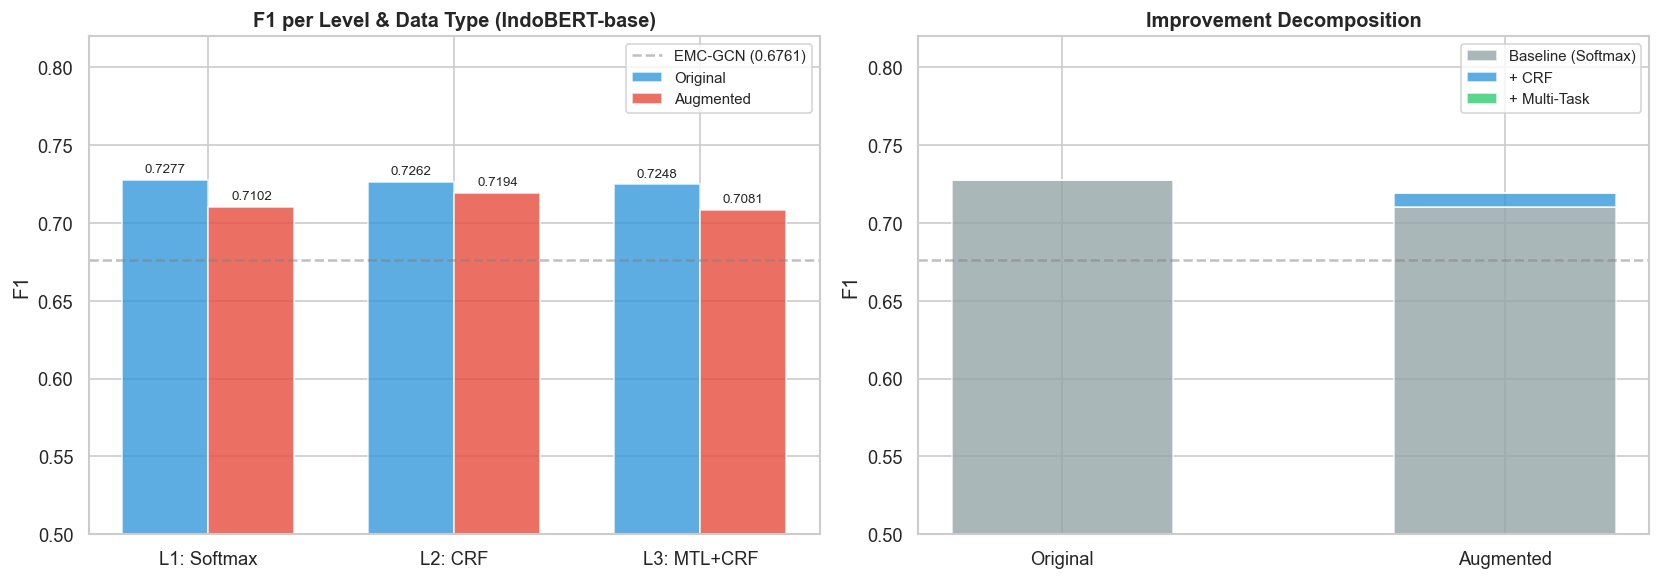

In [9]:
# 3-Level grouped bar + Improvement decomposition
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

levels = ['L1: Softmax', 'L2: CRF', 'L3: MTL+CRF']
orig_f1s = [bl_orig, st_orig, mt_orig]
aug_f1s = [bl_aug, st_aug, mt_aug]

x = np.arange(len(levels))
width = 0.35
bars1 = axes[0].bar(x - width/2, orig_f1s, width, label='Original', color='#3498db', alpha=0.8)
bars2 = axes[0].bar(x + width/2, aug_f1s, width, label='Augmented', color='#e74c3c', alpha=0.8)
axes[0].axhline(PRIOR_RESEARCH_F1, color='gray', linestyle='--', alpha=0.5, label=f'EMC-GCN ({PRIOR_RESEARCH_F1})')

for bars in [bars1, bars2]:
    for bar in bars:
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
                     f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

axes[0].set_title('F1 per Level & Data Type (IndoBERT-base)', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(levels)
axes[0].set_ylabel('F1')
axes[0].legend(fontsize=9)
axes[0].set_ylim(0.50, 0.82)

# Stacked bar decomposition
data_types = ['Original', 'Augmented']
crf_gains = [max(crf_gain_orig, 0), max(crf_gain_aug, 0)]
mtl_gains = [max(mtl_gain_orig, 0), max(mtl_gain_aug, 0)]
baselines = [bl_orig, bl_aug]

x2 = np.arange(len(data_types))
axes[1].bar(x2, baselines, 0.5, label='Baseline (Softmax)', color='#95a5a6', alpha=0.8)
axes[1].bar(x2, crf_gains, 0.5, bottom=baselines, label='+ CRF', color='#3498db', alpha=0.8)
axes[1].bar(x2, mtl_gains, 0.5, bottom=[b + c for b, c in zip(baselines, crf_gains)],
            label='+ Multi-Task', color='#2ecc71', alpha=0.8)
axes[1].axhline(PRIOR_RESEARCH_F1, color='gray', linestyle='--', alpha=0.5)

axes[1].set_title('Improvement Decomposition', fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(data_types)
axes[1].set_ylabel('F1')
axes[1].legend(fontsize=9)
axes[1].set_ylim(0.50, 0.82)

plt.tight_layout()
plt.show()

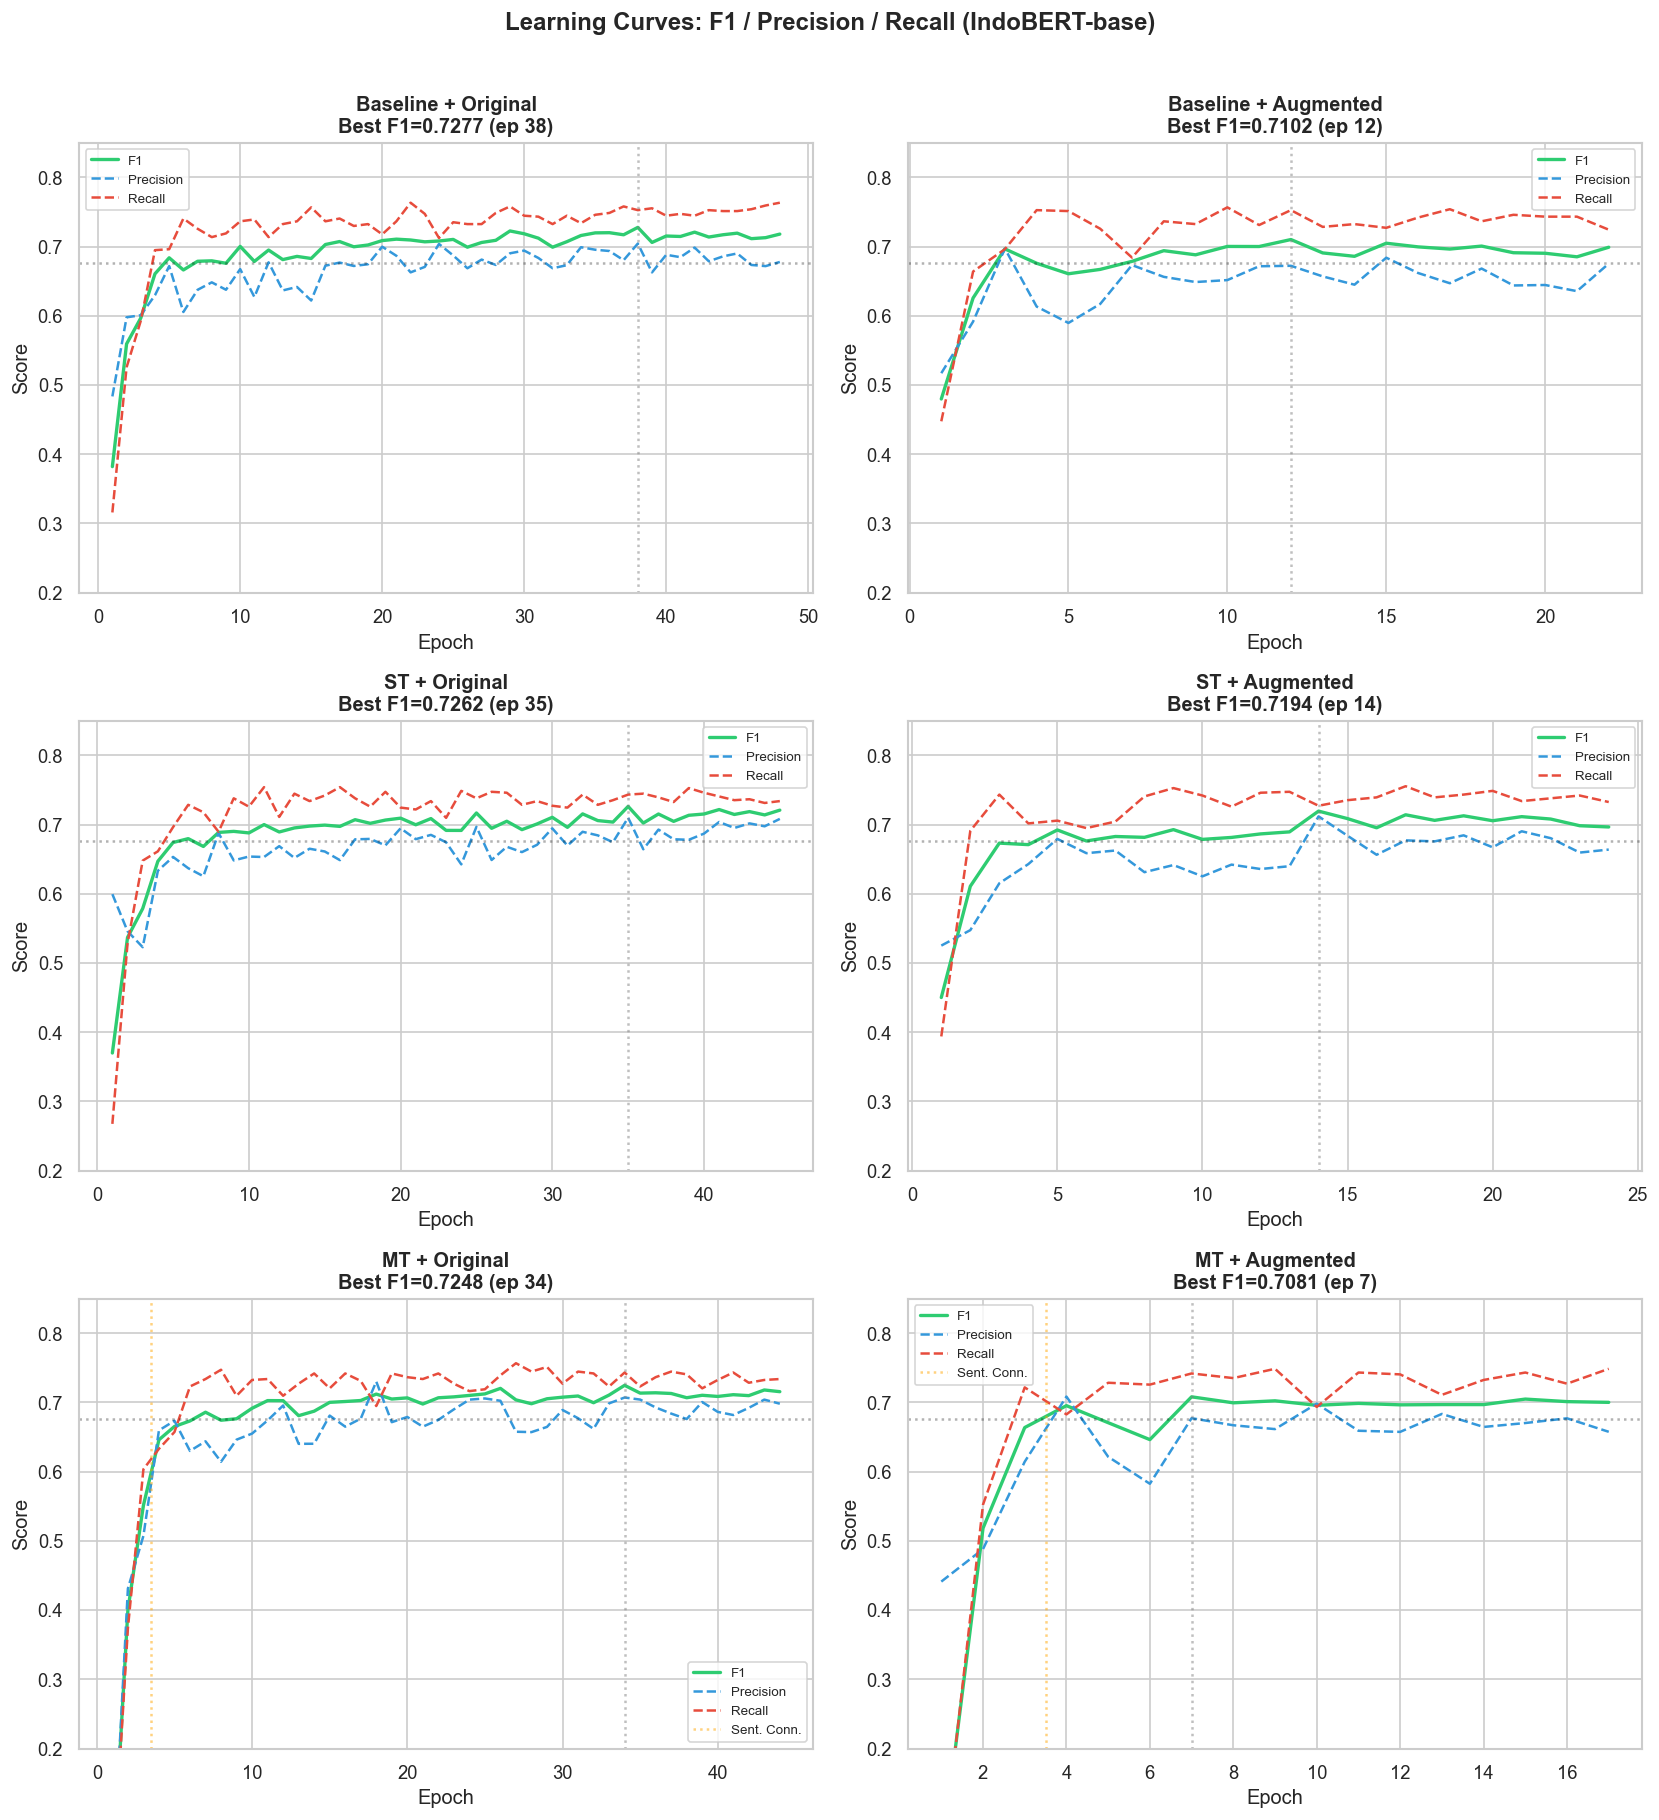

In [10]:
# Learning curves 3x2 (F1, Precision, Recall per run)
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

run_order = [
    ('Baseline + Original', 'Baseline + Augmented'),
    ('ST + Original', 'ST + Augmented'),
    ('MT + Original', 'MT + Augmented'),
]

for row, (left_name, right_name) in enumerate(run_order):
    for col, run_name in enumerate([left_name, right_name]):
        ax = axes[row][col]
        r = all_results[run_name]
        h = r['history']
        epochs = range(1, len(h['val_f1']) + 1)

        ax.plot(epochs, h['val_f1'], label='F1', color='#2ecc71', linewidth=2)
        ax.plot(epochs, h['val_precision'], label='Precision', color='#3498db', linewidth=1.5, linestyle='--')
        ax.plot(epochs, h['val_recall'], label='Recall', color='#e74c3c', linewidth=1.5, linestyle='--')

        best_ep = r['best_epoch']
        ax.axvline(best_ep, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(PRIOR_RESEARCH_F1, color='black', linestyle=':', alpha=0.3)

        if r['model_type'] == 'multi_task':
            ax.axvline(PHASE1_EPOCHS + 0.5, color='orange', linestyle=':', alpha=0.5, label='Sent. Conn.')

        ax.set_title(f'{run_name}\nBest F1={r["best_f1"]:.4f} (ep {best_ep})', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Score')
        ax.legend(fontsize=8)
        ax.set_ylim(0.2, 0.85)

plt.suptitle('Learning Curves: F1 / Precision / Recall (IndoBERT-base)', fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

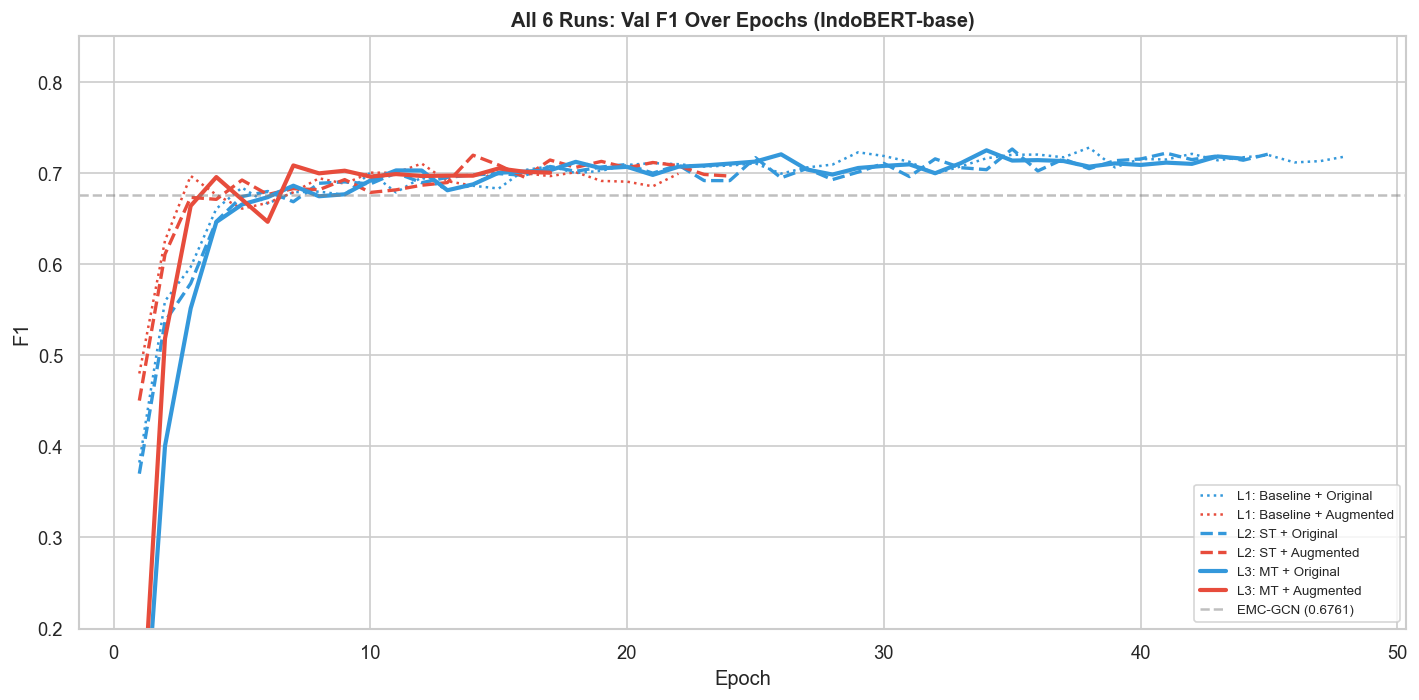

In [11]:
# All 6 F1 curves overlaid
fig, ax = plt.subplots(figsize=(12, 6))

level_styles = {
    1: {'linestyle': ':', 'linewidth': 1.5},
    2: {'linestyle': '--', 'linewidth': 2},
    3: {'linestyle': '-', 'linewidth': 2.5},
}
data_colors = {'original': '#3498db', 'augmented': '#e74c3c'}

for name, r in all_results.items():
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)
    level = r['level']
    data_type = r.get('data_type', 'original' if 'Original' in name else 'augmented')
    style = level_styles[level]
    color = data_colors[data_type]
    ax.plot(epochs, h['val_f1'], label=f'L{level}: {name}', color=color, **style)

ax.axhline(PRIOR_RESEARCH_F1, color='gray', linestyle='--', alpha=0.5,
           label=f'EMC-GCN ({PRIOR_RESEARCH_F1})')
ax.set_title('All 6 Runs: Val F1 Over Epochs (IndoBERT-base)', fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('F1')
ax.legend(fontsize=8, loc='lower right')
ax.set_ylim(0.2, 0.85)

plt.tight_layout()
plt.show()

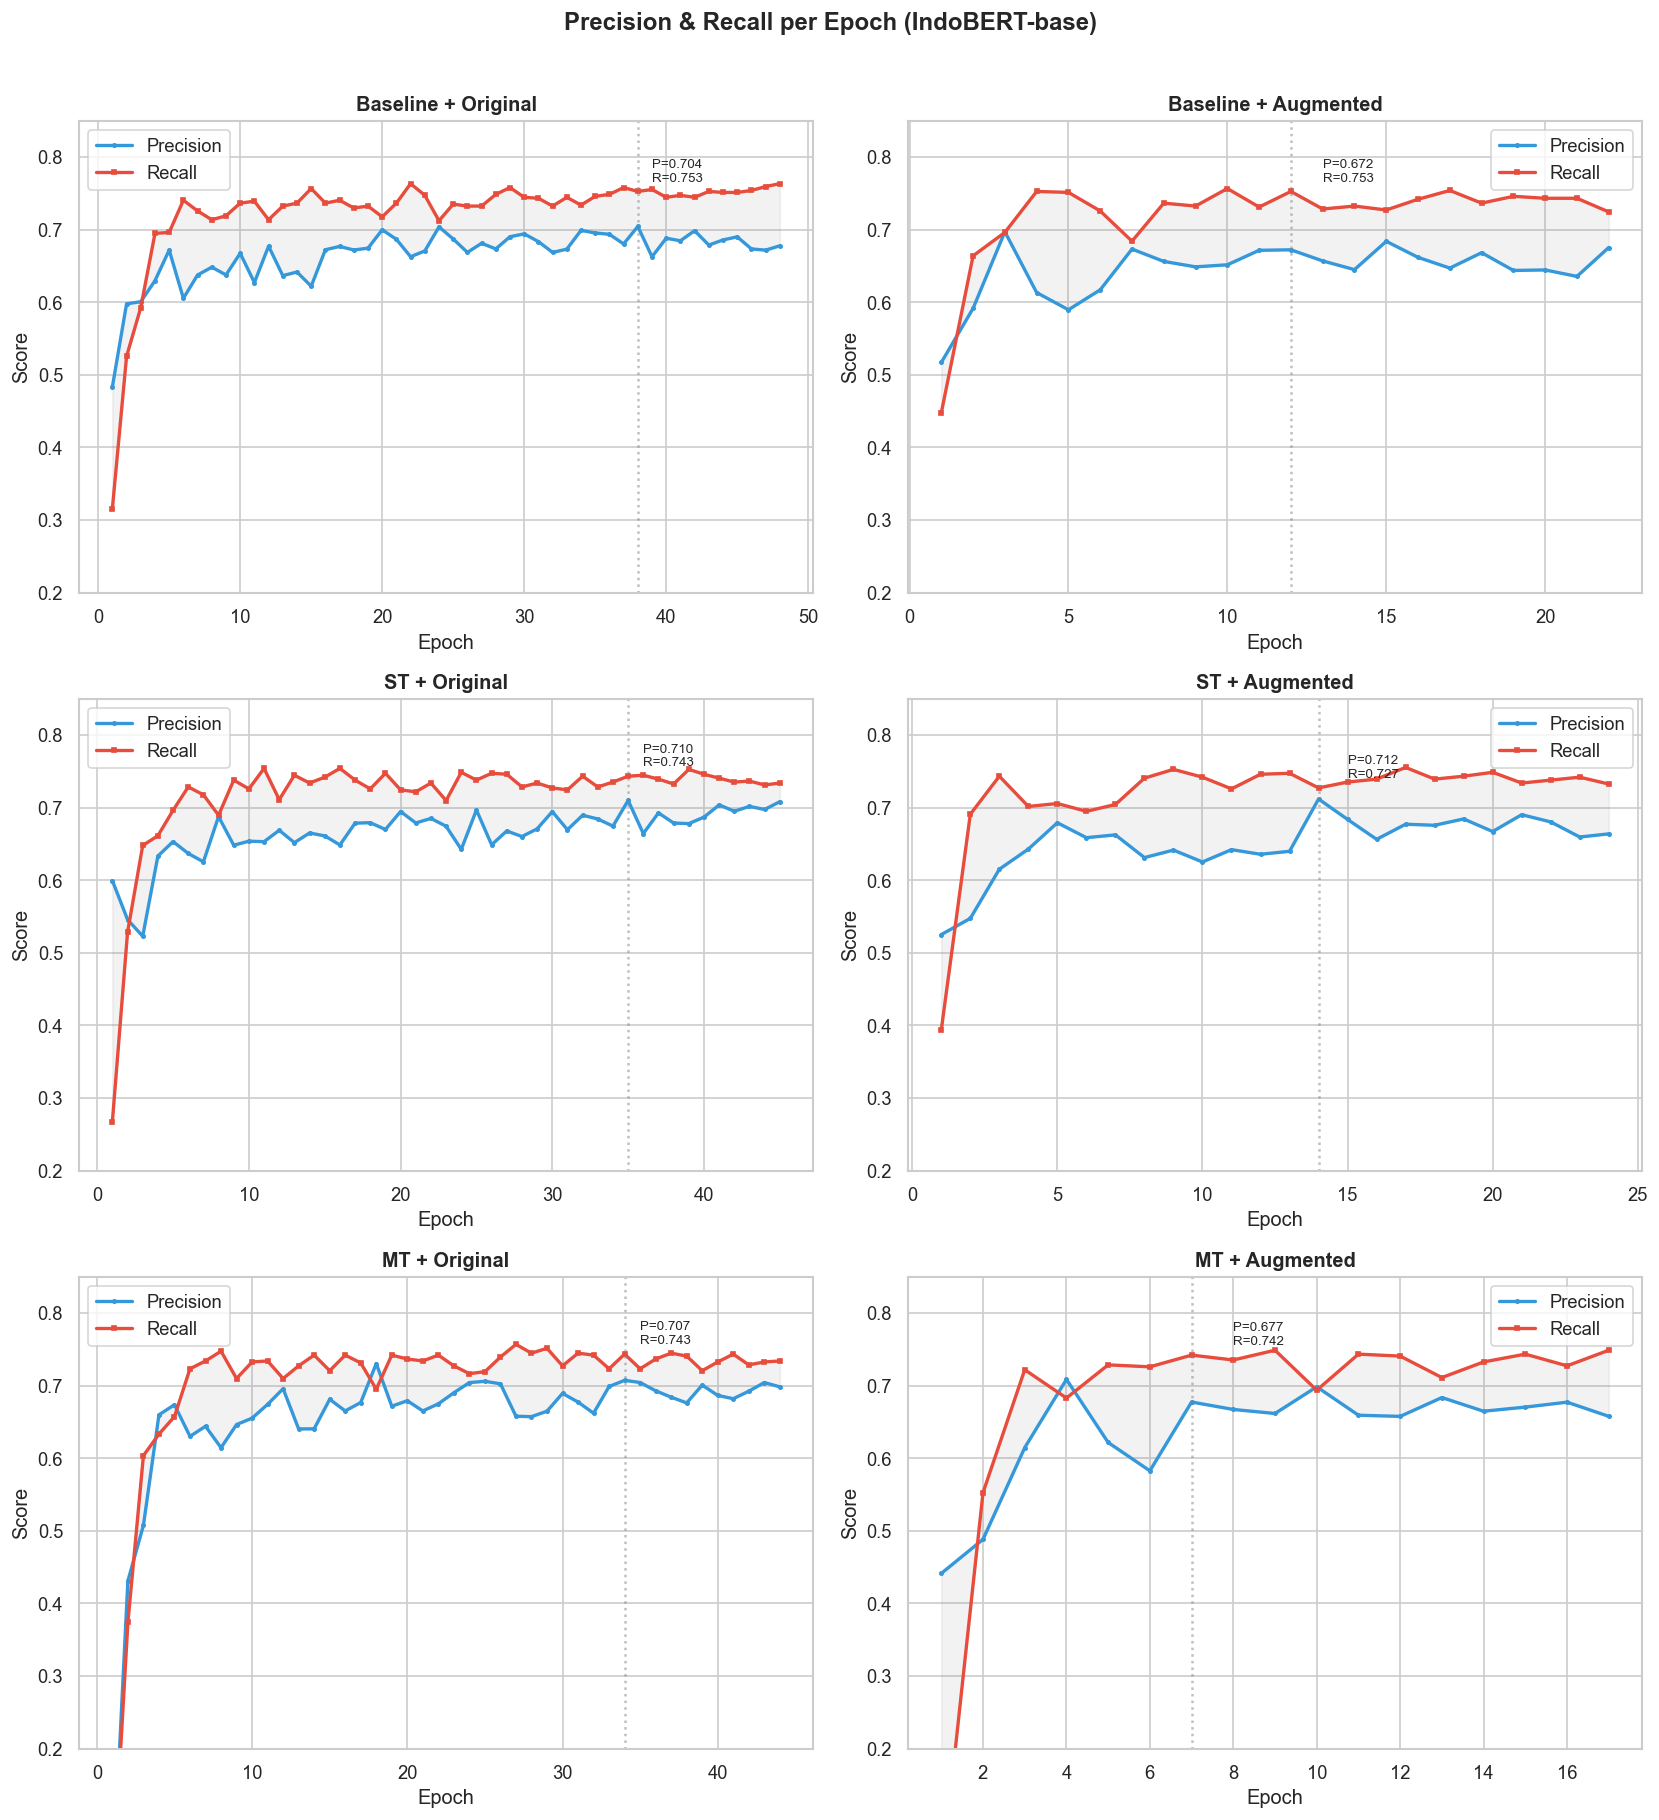

In [12]:
# Precision & Recall per run (3x2)
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

for row, (left_name, right_name) in enumerate(run_order):
    for col, run_name in enumerate([left_name, right_name]):
        ax = axes[row][col]
        r = all_results[run_name]
        h = r['history']
        epochs = range(1, len(h['val_f1']) + 1)

        ax.plot(epochs, h['val_precision'], label='Precision', color='#3498db', linewidth=2, marker='o', markersize=2)
        ax.plot(epochs, h['val_recall'], label='Recall', color='#e74c3c', linewidth=2, marker='s', markersize=2)
        ax.fill_between(epochs, h['val_precision'], h['val_recall'], alpha=0.1, color='gray')

        best_ep = r['best_epoch']
        best_p = h['val_precision'][best_ep - 1]
        best_r = h['val_recall'][best_ep - 1]
        ax.axvline(best_ep, color='gray', linestyle=':', alpha=0.5)
        ax.annotate(f'P={best_p:.3f}\nR={best_r:.3f}', xy=(best_ep, max(best_p, best_r)),
                    fontsize=8, ha='left', va='bottom',
                    xytext=(best_ep + 1, max(best_p, best_r) + 0.01))

        ax.set_title(f'{run_name}', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Score')
        ax.legend()
        ax.set_ylim(0.2, 0.85)

plt.suptitle('Precision & Recall per Epoch (IndoBERT-base)', fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 9. PER-CLASS COMPARISON

In [13]:
# Classification reports
for run_name, r in all_results.items():
    print(f'\n{"="*60}')
    print(f'{run_name} (F1={r["best_f1"]:.4f}, Epoch {r["best_epoch"]})')
    print(f'{"="*60}')
    print(r['report'])

# Cross-level per-class F1
def extract_per_class_f1(report_str):
    result = {}
    for line in report_str.strip().split('\n'):
        line = line.strip()
        for cls in ['NEG', 'NEU', 'POS']:
            if line.startswith(cls):
                parts = line.split()
                result[cls] = {'precision': float(parts[1]), 'recall': float(parts[2]), 'f1': float(parts[3])}
    return result

for data_label, runs_list in [('Original', ['Baseline + Original', 'ST + Original', 'MT + Original']),
                               ('Augmented', ['Baseline + Augmented', 'ST + Augmented', 'MT + Augmented'])]:
    print(f'\n{"="*70}')
    print(f'CROSS-LEVEL PER-CLASS F1 ({data_label} Data)')
    print(f'{"="*70}')
    print(f'\n{"":>15s} {"NEG":>20s} {"NEU":>20s} {"POS":>20s}')
    print(f'{"":>15s} {"P     R     F1":>20s} {"P     R     F1":>20s} {"P     R     F1":>20s}')
    print('-' * 78)
    level_labels = ['L1: Baseline', 'L2: CRF', 'L3: MTL']
    for label_str, rn in zip(level_labels, runs_list):
        cls = extract_per_class_f1(all_results[rn]['report'])
        neg = cls.get('NEG', {'precision': 0, 'recall': 0, 'f1': 0})
        neu = cls.get('NEU', {'precision': 0, 'recall': 0, 'f1': 0})
        pos = cls.get('POS', {'precision': 0, 'recall': 0, 'f1': 0})
        print(f'{label_str:>15s} '
              f'{neg["precision"]:.2f}  {neg["recall"]:.2f}  {neg["f1"]:.2f}      '
              f'{neu["precision"]:.2f}  {neu["recall"]:.2f}  {neu["f1"]:.2f}      '
              f'{pos["precision"]:.2f}  {pos["recall"]:.2f}  {pos["f1"]:.2f}')


Baseline + Original (F1=0.7277, Epoch 38)
              precision    recall  f1-score   support

         NEG       0.49      0.58      0.53        83
         NEU       0.54      0.64      0.59       125
         POS       0.79      0.81      0.80       536

   micro avg       0.70      0.75      0.73       744
   macro avg       0.61      0.67      0.64       744
weighted avg       0.71      0.75      0.73       744


Baseline + Augmented (F1=0.7102, Epoch 12)
              precision    recall  f1-score   support

         NEG       0.48      0.55      0.51        83
         NEU       0.51      0.61      0.55       125
         POS       0.74      0.82      0.78       536

   micro avg       0.67      0.75      0.71       744
   macro avg       0.58      0.66      0.62       744
weighted avg       0.68      0.75      0.71       744


ST + Original (F1=0.7262, Epoch 35)
              precision    recall  f1-score   support

         NEG       0.56      0.64      0.60        83
     

### 10. MULTI-TASK SUBTASK LOSSES

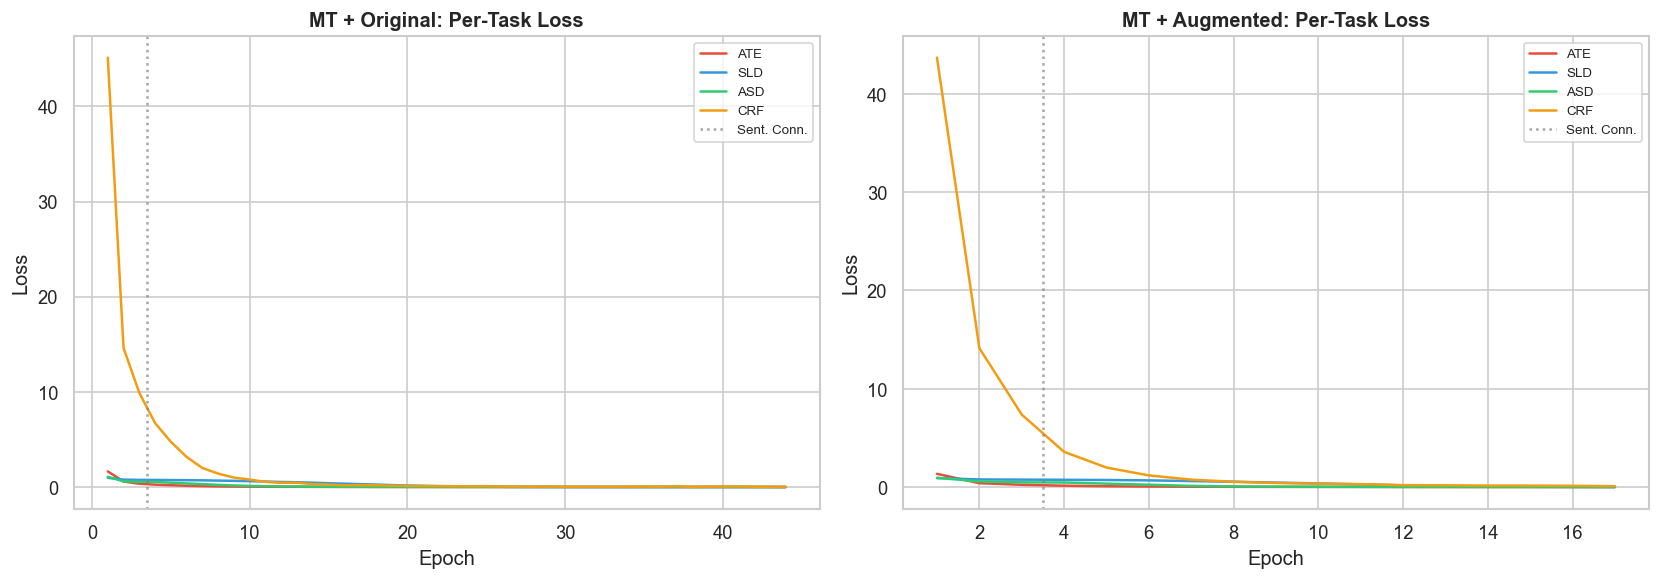

In [14]:
mt_runs = [(n, r) for n, r in all_results.items() if r['model_type'] == 'multi_task']

if len(mt_runs) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    task_colors = {'ate': '#e74c3c', 'sld': '#3498db', 'asd': '#2ecc71', 'crf': '#f39c12'}

    for idx, (run_name, r) in enumerate(mt_runs):
        ax = axes[idx]
        h = r['history']
        epochs = range(1, len(h['val_f1']) + 1)
        for task in ['ate', 'sld', 'asd', 'crf']:
            if f'loss_{task}' in h:
                ax.plot(epochs, h[f'loss_{task}'], label=task.upper(),
                        color=task_colors[task], linewidth=1.5)
        ax.axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Conn.')
        ax.set_title(f'{run_name}: Per-Task Loss', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()
elif len(mt_runs) == 1:
    run_name, r = mt_runs[0]
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)
    fig, ax = plt.subplots(figsize=(8, 5))
    task_colors = {'ate': '#e74c3c', 'sld': '#3498db', 'asd': '#2ecc71', 'crf': '#f39c12'}
    for task in ['ate', 'sld', 'asd', 'crf']:
        if f'loss_{task}' in h:
            ax.plot(epochs, h[f'loss_{task}'], label=task.upper(),
                    color=task_colors[task], linewidth=1.5)
    ax.axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Conn.')
    ax.set_title(f'{run_name}: Per-Task Loss', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.tight_layout()
    plt.show()

### 11. CROSS-MODEL SIZE COMPARISON (base vs large)

Membandingkan hasil IndoBERT-base (notebook ini) dengan IndoBERT-large (NB11).
Hipotesis: MTL contribution lebih besar pada base model.

In [15]:
if os.path.exists(NB11_CHECKPOINT):
    nb11 = torch.load(NB11_CHECKPOINT, weights_only=False)
    large_results = nb11['all_results']
    large_decomp = nb11['decomposition']

    print('=' * 90)
    print('CROSS-MODEL SIZE COMPARISON: IndoBERT-base vs IndoBERT-large')
    print('=' * 90)

    # F1 comparison table
    print(f'\n{"":>30s} {"Base":>10s} {"Large":>10s} {"Diff":>10s}')
    print('-' * 65)

    name_mapping = {
        'Baseline + Original':  'Baseline + Original',
        'Baseline + Augmented': 'Baseline + Augmented',
        'ST + Original':        'ST + Original',
        'ST + Augmented':       'ST + Augmented',
        'MT + Original':        'MT + Original',
        'MT + Augmented':       'MT + Augmented',
    }

    for base_name, large_name in name_mapping.items():
        if base_name in all_results and large_name in large_results:
            bf1 = all_results[base_name]['best_f1']
            lf1 = large_results[large_name]['best_f1']
            diff = bf1 - lf1
            lvl = all_results[base_name]['level']
            print(f'  L{lvl} {base_name:<25s} {bf1:>10.4f} {lf1:>10.4f} {diff:>+10.4f}')

    # Decomposition comparison
    print(f'\n{"="*70}')
    print('DECOMPOSITION COMPARISON')
    print(f'{"="*70}')
    print(f'\n{"":>25s} {"Base (orig)":>12s} {"Large (orig)":>12s} {"Base (aug)":>12s} {"Large (aug)":>12s}')
    print('-' * 78)

    l_crf_orig = large_decomp['original']['crf_gain']
    l_mtl_orig = large_decomp['original']['mtl_gain']
    l_total_orig = large_decomp['original']['total_gain']
    l_crf_aug = large_decomp['augmented']['crf_gain']
    l_mtl_aug = large_decomp['augmented']['mtl_gain']
    l_total_aug = large_decomp['augmented']['total_gain']

    print(f'{"CRF (L2-L1)":>25s} {crf_gain_orig:>+12.4f} {l_crf_orig:>+12.4f} {crf_gain_aug:>+12.4f} {l_crf_aug:>+12.4f}')
    print(f'{"MTL (L3-L2)":>25s} {mtl_gain_orig:>+12.4f} {l_mtl_orig:>+12.4f} {mtl_gain_aug:>+12.4f} {l_mtl_aug:>+12.4f}')
    print(f'{"Total (L3-L1)":>25s} {total_gain_orig:>+12.4f} {l_total_orig:>+12.4f} {total_gain_aug:>+12.4f} {l_total_aug:>+12.4f}')

    # Key insight
    print(f'\nKey Insight:')
    mtl_base_avg = (mtl_gain_orig + mtl_gain_aug) / 2
    mtl_large_avg = (l_mtl_orig + l_mtl_aug) / 2
    crf_base_avg = (crf_gain_orig + crf_gain_aug) / 2
    crf_large_avg = (l_crf_orig + l_crf_aug) / 2
    print(f'  CRF avg gain  -> Base: {crf_base_avg:+.4f} | Large: {crf_large_avg:+.4f}')
    print(f'  MTL avg gain  -> Base: {mtl_base_avg:+.4f} | Large: {mtl_large_avg:+.4f}')
    if mtl_base_avg > mtl_large_avg:
        print(f'  -> MTL memberikan kontribusi LEBIH BESAR pada base model (+{mtl_base_avg - mtl_large_avg:.4f})')
    else:
        print(f'  -> MTL memberikan kontribusi lebih kecil pada base model ({mtl_base_avg - mtl_large_avg:+.4f})')
else:
    print('NB11 checkpoint not found. Skipping cross-model comparison.')
    print(f'Expected: {NB11_CHECKPOINT}')
    large_results = None

CROSS-MODEL SIZE COMPARISON: IndoBERT-base vs IndoBERT-large

                                     Base      Large       Diff
-----------------------------------------------------------------
  L1 Baseline + Original           0.7277     0.7466    -0.0188
  L1 Baseline + Augmented          0.7102     0.7593    -0.0491
  L2 ST + Original                 0.7262     0.7558    -0.0296
  L2 ST + Augmented                0.7194     0.7600    -0.0406
  L3 MT + Original                 0.7248     0.7578    -0.0330
  L3 MT + Augmented                0.7081     0.7442    -0.0361

DECOMPOSITION COMPARISON

                           Base (orig) Large (orig)   Base (aug)  Large (aug)
------------------------------------------------------------------------------
              CRF (L2-L1)      -0.0015      +0.0092      +0.0092      +0.0007
              MTL (L3-L2)      -0.0014      +0.0021      -0.0113      -0.0158
            Total (L3-L1)      -0.0030      +0.0113      -0.0021      -0.0151

Key I

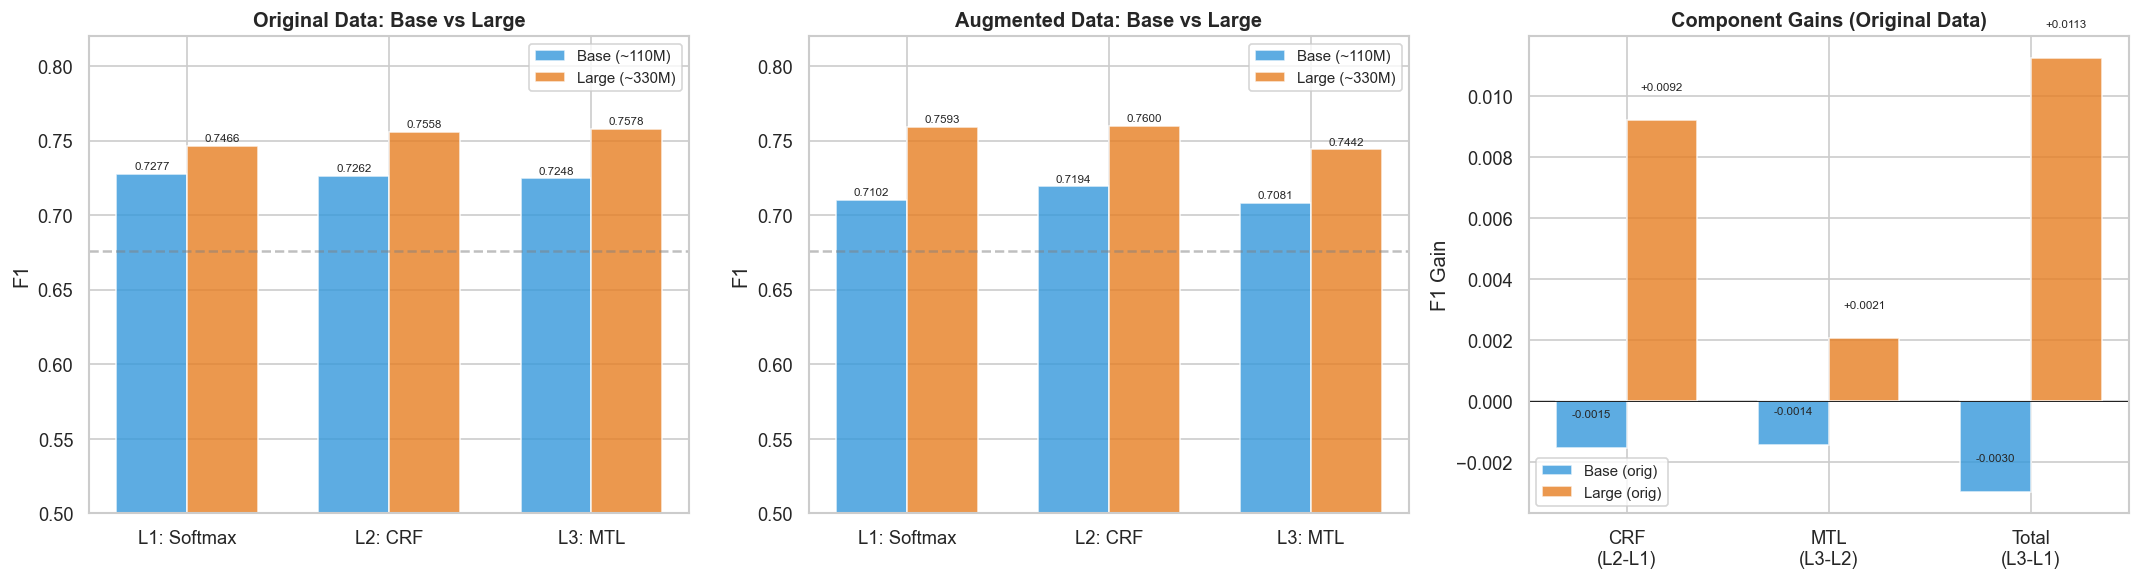

In [16]:
# Cross-model visualization
if large_results is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Left: Base vs Large F1 per level (Original data)
    levels = ['L1: Softmax', 'L2: CRF', 'L3: MTL']
    base_orig = [bl_orig, st_orig, mt_orig]
    large_orig = [
        large_results.get('Baseline + Original', {}).get('best_f1', 0),
        large_results.get('ST + Original', {}).get('best_f1', 0),
        large_results.get('MT + Original', {}).get('best_f1', 0),
    ]

    x = np.arange(len(levels))
    width = 0.35
    axes[0].bar(x - width/2, base_orig, width, label='Base (~110M)', color='#3498db', alpha=0.8)
    axes[0].bar(x + width/2, large_orig, width, label='Large (~330M)', color='#e67e22', alpha=0.8)
    axes[0].axhline(PRIOR_RESEARCH_F1, color='gray', linestyle='--', alpha=0.5)
    for i in range(len(levels)):
        axes[0].text(x[i] - width/2, base_orig[i] + 0.003, f'{base_orig[i]:.4f}', ha='center', fontsize=7)
        axes[0].text(x[i] + width/2, large_orig[i] + 0.003, f'{large_orig[i]:.4f}', ha='center', fontsize=7)
    axes[0].set_title('Original Data: Base vs Large', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(levels)
    axes[0].set_ylabel('F1')
    axes[0].legend(fontsize=9)
    axes[0].set_ylim(0.50, 0.82)

    # Middle: Base vs Large F1 per level (Augmented data)
    base_aug = [bl_aug, st_aug, mt_aug]
    large_aug = [
        large_results.get('Baseline + Augmented', {}).get('best_f1', 0),
        large_results.get('ST + Augmented', {}).get('best_f1', 0),
        large_results.get('MT + Augmented', {}).get('best_f1', 0),
    ]

    axes[1].bar(x - width/2, base_aug, width, label='Base (~110M)', color='#3498db', alpha=0.8)
    axes[1].bar(x + width/2, large_aug, width, label='Large (~330M)', color='#e67e22', alpha=0.8)
    axes[1].axhline(PRIOR_RESEARCH_F1, color='gray', linestyle='--', alpha=0.5)
    for i in range(len(levels)):
        axes[1].text(x[i] - width/2, base_aug[i] + 0.003, f'{base_aug[i]:.4f}', ha='center', fontsize=7)
        axes[1].text(x[i] + width/2, large_aug[i] + 0.003, f'{large_aug[i]:.4f}', ha='center', fontsize=7)
    axes[1].set_title('Augmented Data: Base vs Large', fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(levels)
    axes[1].set_ylabel('F1')
    axes[1].legend(fontsize=9)
    axes[1].set_ylim(0.50, 0.82)

    # Right: Component gains comparison
    components = ['CRF\n(L2-L1)', 'MTL\n(L3-L2)', 'Total\n(L3-L1)']
    base_gains_orig = [crf_gain_orig, mtl_gain_orig, total_gain_orig]
    large_gains_orig = [l_crf_orig, l_mtl_orig, l_total_orig]

    x3 = np.arange(len(components))
    axes[2].bar(x3 - width/2, base_gains_orig, width, label='Base (orig)', color='#3498db', alpha=0.8)
    axes[2].bar(x3 + width/2, large_gains_orig, width, label='Large (orig)', color='#e67e22', alpha=0.8)
    axes[2].axhline(0, color='black', linewidth=0.5)
    for i in range(len(components)):
        axes[2].text(x3[i] - width/2, base_gains_orig[i] + 0.001, f'{base_gains_orig[i]:+.4f}', ha='center', fontsize=7)
        axes[2].text(x3[i] + width/2, large_gains_orig[i] + 0.001, f'{large_gains_orig[i]:+.4f}', ha='center', fontsize=7)
    axes[2].set_title('Component Gains (Original Data)', fontweight='bold')
    axes[2].set_xticks(x3)
    axes[2].set_xticklabels(components)
    axes[2].set_ylabel('F1 Gain')
    axes[2].legend(fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print('Skipping cross-model visualization (no NB11 data).')

### 12. KESIMPULAN

In [17]:
print('=' * 60)
print('KESIMPULAN: IndoBERT-base 3-Level Comparison')
print('=' * 60)

# Ranking
sorted_runs = sorted(all_results.items(), key=lambda x: x[1]['best_f1'], reverse=True)

print('\nRanking F1 (IndoBERT-base):')
for i, (name, r) in enumerate(sorted_runs):
    print(f'  {i+1}. L{r["level"]} {name:<25s} F1={r["best_f1"]:.4f} (ep {r["best_epoch"]})')

# Decomposition
print(f'\nDekomposisi (Original data):')
print(f'  Baseline (Softmax)    : {bl_orig:.4f}')
print(f'  + CRF                 : {crf_gain_orig:+.4f} -> {st_orig:.4f}')
print(f'  + Multi-Task Learning : {mtl_gain_orig:+.4f} -> {mt_orig:.4f}')

print(f'\nDekomposisi (Augmented data):')
print(f'  Baseline (Softmax)    : {bl_aug:.4f}')
print(f'  + CRF                 : {crf_gain_aug:+.4f} -> {st_aug:.4f}')
print(f'  + Multi-Task Learning : {mtl_gain_aug:+.4f} -> {mt_aug:.4f}')

# vs EMC-GCN
print(f'\nSemua konfigurasi vs EMC-GCN ({PRIOR_RESEARCH_F1}):')
for name, r in sorted_runs:
    diff = r['best_f1'] - PRIOR_RESEARCH_F1
    status = 'ABOVE' if diff > 0 else 'BELOW'
    print(f'  L{r["level"]} {name:<25s}: {diff:+.4f} ({status})')

# Cross-model summary
if large_results is not None:
    print(f'\n{"="*60}')
    print('CROSS-MODEL SUMMARY (base vs large)')
    print(f'{"="*60}')
    print(f'\n{"":>25s} {"Base":>10s} {"Large":>10s}')
    print('-' * 50)
    print(f'{"CRF gain (orig)":>25s} {crf_gain_orig:>+10.4f} {l_crf_orig:>+10.4f}')
    print(f'{"MTL gain (orig)":>25s} {mtl_gain_orig:>+10.4f} {l_mtl_orig:>+10.4f}')
    print(f'{"CRF gain (aug)":>25s} {crf_gain_aug:>+10.4f} {l_crf_aug:>+10.4f}')
    print(f'{"MTL gain (aug)":>25s} {mtl_gain_aug:>+10.4f} {l_mtl_aug:>+10.4f}')

    print(f'\nInterpretasi untuk thesis:')
    if mtl_gain_orig > l_mtl_orig:
        print(f'  -> Pada data original, MTL lebih efektif di base ({mtl_gain_orig:+.4f}) vs large ({l_mtl_orig:+.4f})')
    else:
        print(f'  -> Pada data original, MTL tidak lebih efektif di base ({mtl_gain_orig:+.4f}) vs large ({l_mtl_orig:+.4f})')
    if mtl_gain_aug > l_mtl_aug:
        print(f'  -> Pada data augmented, MTL lebih efektif di base ({mtl_gain_aug:+.4f}) vs large ({l_mtl_aug:+.4f})')
    else:
        print(f'  -> Pada data augmented, MTL tidak lebih efektif di base ({mtl_gain_aug:+.4f}) vs large ({l_mtl_aug:+.4f})')

KESIMPULAN: IndoBERT-base 3-Level Comparison

Ranking F1 (IndoBERT-base):
  1. L1 Baseline + Original       F1=0.7277 (ep 38)
  2. L2 ST + Original             F1=0.7262 (ep 35)
  3. L3 MT + Original             F1=0.7248 (ep 34)
  4. L2 ST + Augmented            F1=0.7194 (ep 14)
  5. L1 Baseline + Augmented      F1=0.7102 (ep 12)
  6. L3 MT + Augmented            F1=0.7081 (ep 7)

Dekomposisi (Original data):
  Baseline (Softmax)    : 0.7277
  + CRF                 : -0.0015 -> 0.7262
  + Multi-Task Learning : -0.0014 -> 0.7248

Dekomposisi (Augmented data):
  Baseline (Softmax)    : 0.7102
  + CRF                 : +0.0092 -> 0.7194
  + Multi-Task Learning : -0.0113 -> 0.7081

Semua konfigurasi vs EMC-GCN (0.6761):
  L1 Baseline + Original      : +0.0516 (ABOVE)
  L2 ST + Original            : +0.0501 (ABOVE)
  L3 MT + Original            : +0.0487 (ABOVE)
  L2 ST + Augmented           : +0.0433 (ABOVE)
  L1 Baseline + Augmented     : +0.0341 (ABOVE)
  L3 MT + Augmented           : 

### 13. SIMPAN HASIL

In [ ]:
checkpoint = {
    'all_results': all_results,
    'decomposition': {
        'original': {
            'baseline': bl_orig, 'crf_gain': crf_gain_orig,
            'mtl_gain': mtl_gain_orig, 'total_gain': total_gain_orig,
        },
        'augmented': {
            'baseline': bl_aug, 'crf_gain': crf_gain_aug,
            'mtl_gain': mtl_gain_aug, 'total_gain': total_gain_aug,
        },
    },
    'config': {
        'model_name': MODEL_NAME,
        'num_epochs': NUM_EPOCHS,
        'patience': PATIENCE,
        'dropout': DROPOUT,
        'weight_decay': WEIGHT_DECAY,
        'lr_bert': LR_BERT,
        'lr_head': LR_HEAD,
        'batch_size': BATCH_SIZE * GRADIENT_ACCUMULATION,
        'lambda1': LAMBDA1,
        'lambda2': LAMBDA2,
        'phase1_epochs': PHASE1_EPOCHS,
        'seed': SEED,
    },
    'prior_research_f1': PRIOR_RESEARCH_F1,
}

save_path = os.path.join(MODEL_DIR, 'checkpoint_base_model.pt')
torch.save(checkpoint, save_path)

file_size = os.path.getsize(save_path) / (1024**2)
print(f'Checkpoint saved: {save_path}')
print(f'File size: {file_size:.1f} MB')

best_name = max(all_results, key=lambda k: all_results[k]['best_f1'])
print(f'\nBest overall: {best_name} (F1={all_results[best_name]["best_f1"]:.4f})')

Checkpoint saved: d:\Kuliah\TA\Notebook\models\checkpoint_base_model.pt
File size: 0.5 MB

Best overall: Baseline + Original (F1=0.7277)


: 